# Wettervorhersage mit Regression Tree Algorithmen
---
Das Ziel dieses Projekts besteht darin, die Niederschlags- und Lufttemperaturwerte drei Tage in die Zukunft mithilfe von Maschinelerning-Algorithmen, hier insbesondere dem Regression Tree, vorherzusagen. Die zugrundeliegenden Daten stammen aus drei verschiedenen Wetterstationen.

## Datenstruktur:

Jede Zeile in den CSV-Dateien repräsentiert einen Tag, wobei verschiedene meteorologische Instrumente unterschiedliche Parameter aufzeichnen. Die verfügbaren Spalten für die Vorhersage umfassen die folgenden Features:
- `DATE`
- `MESS_DATUM`
- `QUALITAETS_NIVEAU`
- `LUFTTEMPERATUR`
- `DAMPFDRUCK`
- `BEDECKUNGSGRAD`
- `LUFTDRUCK_STATIONSHOEHE`
- `REL_FEUCHTE`
- `WINDGESCHWINDIGKEIT`
- `LUFTTEMPERATUR_MAXIMUM`
- `LUFTTEMPERATUR_MINIMUM`
- `LUFTTEMP_AM_ERDB_MINIMUM`
- `WINDSPITZE_MAXIMUM`
- `NIEDERSCHLAGSHOEHE`
- `NIEDERSCHLAGSHOEHE_IND`
- `SONNENSCHEINDAUER`
- `SCHNEEHOEHE`

## Zunächst werden hier die benötigten imports getätigt.

In [1]:
# Import der Bibliotheken
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import linear_model

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms
import math

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

## Daten Importieren
Die Daten werden vorverarbeitet, wobei die Zielvariablen in Beziehung zu den vorhandenen Daten gesetzt werden. 
Zusätzlich erfolgt eine Interpolation oder Entfernung nicht vorhandener Daten.

In [2]:
# Seperation von Featchers und Zieldaten (x, y)

from pathlib import Path
cwd = str(Path.cwd())

X = pd.read_csv(cwd + "/../data/Featchers_randomized.csv")
Y = pd.read_csv(cwd + "/../data/Goals_randomized.csv")
D = pd.read_csv(cwd + "/../data/Timings_randomized.csv").sort_index(axis=1)

D['straubing_DATE'] = pd.to_datetime(D['straubing_DATE'], format='%d.%m.%Y')

X_Val = X.values

Y_Temp_1 = Y[["straubing_LUFTTEMPERATUR_future_1Day"]].values.flatten()
Y_Temp_2 = Y[["straubing_LUFTTEMPERATUR_future_2Day"]].values.flatten()
Y_Temp_3 = Y[["straubing_LUFTTEMPERATUR_future_3Day"]].values.flatten()
Y_Reg_1 = Y[["straubing_NIEDERSCHLAGSHOEHE_future_1Day"]].values.flatten()
Y_Reg_2 = Y[["straubing_NIEDERSCHLAGSHOEHE_future_2Day"]].values.flatten()
Y_Reg_3 = Y[["straubing_NIEDERSCHLAGSHOEHE_future_3Day"]].values.flatten()

## Der RandomForestRegressor

In [4]:
def randomForest(X, Y, n_estimators, max_depth, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    rf_regressor = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, max_depth=max_depth)
    rf_regressor.fit(X_train, y_train)
    
    y_pred_test = rf_regressor.predict(X_test)
    y_pred_train = rf_regressor.predict(X_train)

    return (y_test, y_pred_test, y_train, y_pred_train, rf_regressor)

## Der GradientBoostingRegressor

In [5]:
def boosting(X, Y, n_estimators, max_depth, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    gb_regressor = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth)
    gb_regressor.fit(X_train, y_train)
    
    y_pred_test = gb_regressor.predict(X_test)
    y_pred_train = gb_regressor.predict(X_train)
    
    return (y_test, y_pred_test, y_train, y_pred_train, gb_regressor)

## Der BaggingRegressor mit RandomForestRegressor estimator

In [6]:
def bagging(X, Y, n_estimators, max_depth, test_size):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    bg_regressor = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, max_depth=max_depth), n_estimators=n_estimators)
    bg_regressor.fit(X_train, y_train)
    
    y_pred_test = bg_regressor.predict(X_test)
    y_pred_train = bg_regressor.predict(X_train)
    
    return (y_test, y_pred_test, y_train, y_pred_train, bg_regressor)

## Parameter Check
Hier wird überprüft welhe Parameter für welches Modell am besten passt.

In [7]:
estimators_range = range(1, 40, 3)
depth_range = range(1, 25, 3)
split_range = range(5, 25, 3)

collection_column_name = ["Key"] + [f'{option}_{method}_{dat}_{ml}' for ml in ["RF", "GB", "BG"] for option in ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"] for method in ["mse", "r2"] for dat in ["test", "train"]]

estimatorsCollection = pd.DataFrame(columns=collection_column_name)
depthCollection = pd.DataFrame(columns=collection_column_name)
splitCollection = pd.DataFrame(columns=collection_column_name)

for est in estimators_range:
    res = {}
    res["Key"] = est
    targets = ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]
    for target in targets:
        for method, estimators, depth, split, shortname in [(randomForest, est, 18, 0.12, "RF"), (boosting, est, 7, 0.12, "GB"), (bagging, est, 20, 0.14, "BG")]:
            y_test, y_pred_test, y_train, y_pred_train, reg = method(X_Val, globals()[f"Y_{target}"], estimators, depth, split)
            res[f"{target}_mse_test_{shortname}"] = mean_squared_error(y_test, y_pred_test)
            res[f"{target}_mse_train_{shortname}"] = mean_squared_error(y_train, y_pred_train)
            res[f"{target}_r2_test_{shortname}"] = r2_score(y_test, y_pred_test)
            res[f"{target}_r2_train_{shortname}"] = r2_score(y_train, y_pred_train)
        
    estimatorsCollection = pd.concat([estimatorsCollection, pd.DataFrame([res])], ignore_index=True)
    print("Estimators: ", est)

for depth in depth_range:
    res = {}
    res["Key"] = depth
    targets = ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]
    for target in targets:
        for method, estimators, depth, split, shortname in [(randomForest, 43, depth, 0.12, "RF"), (boosting, 20, depth, 0.12, "GB"), (bagging, 30, depth, 0.14, "BG")]:
            y_test, y_pred_test, y_train, y_pred_train, reg = method(X_Val, globals()[f"Y_{target}"], estimators, depth, split)
            res[f"{target}_mse_test_{shortname}"] = mean_squared_error(y_test, y_pred_test)
            res[f"{target}_mse_train_{shortname}"] = mean_squared_error(y_train, y_pred_train)
            res[f"{target}_r2_test_{shortname}"] = r2_score(y_test, y_pred_test)
            res[f"{target}_r2_train_{shortname}"] = r2_score(y_train, y_pred_train)
        
    depthCollection = pd.concat([depthCollection, pd.DataFrame([res])], ignore_index=True)
    print("Depth: ", depth)

for split in split_range:
    res = {}
    res["Key"] = split / 100
    targets = ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]
    for target in targets:
        for method, estimators, depth, fsplit, shortname in [(randomForest, 43, 18, split / 100, "RF"), (boosting, 20, 7, split / 100, "GB"), (bagging, 30, 20, split / 100, "BG")]:
            y_test, y_pred_test, y_train, y_pred_train, reg = method(X_Val, globals()[f"Y_{target}"], estimators, depth, fsplit)
            res[f"{target}_mse_test_{shortname}"] = mean_squared_error(y_test, y_pred_test)
            res[f"{target}_mse_train_{shortname}"] = mean_squared_error(y_train, y_pred_train)
            res[f"{target}_r2_test_{shortname}"] = r2_score(y_test, y_pred_test)
            res[f"{target}_r2_train_{shortname}"] = r2_score(y_train, y_pred_train)
        
    splitCollection = pd.concat([splitCollection, pd.DataFrame([res])], ignore_index=True)
    print("Split: ", split)

Estimators:  1
Estimators:  4
Estimators:  7
Estimators:  10
Estimators:  13
Estimators:  16
Estimators:  19
Estimators:  22
Estimators:  25
Estimators:  28
Estimators:  31
Estimators:  34
Estimators:  37
Depth:  1
Depth:  4
Depth:  7
Depth:  10
Depth:  13
Depth:  16
Depth:  19
Depth:  22
Split:  5
Split:  8
Split:  11
Split:  14
Split:  17
Split:  20
Split:  23


## Auswertung der Parameter im zusammenhang zum score

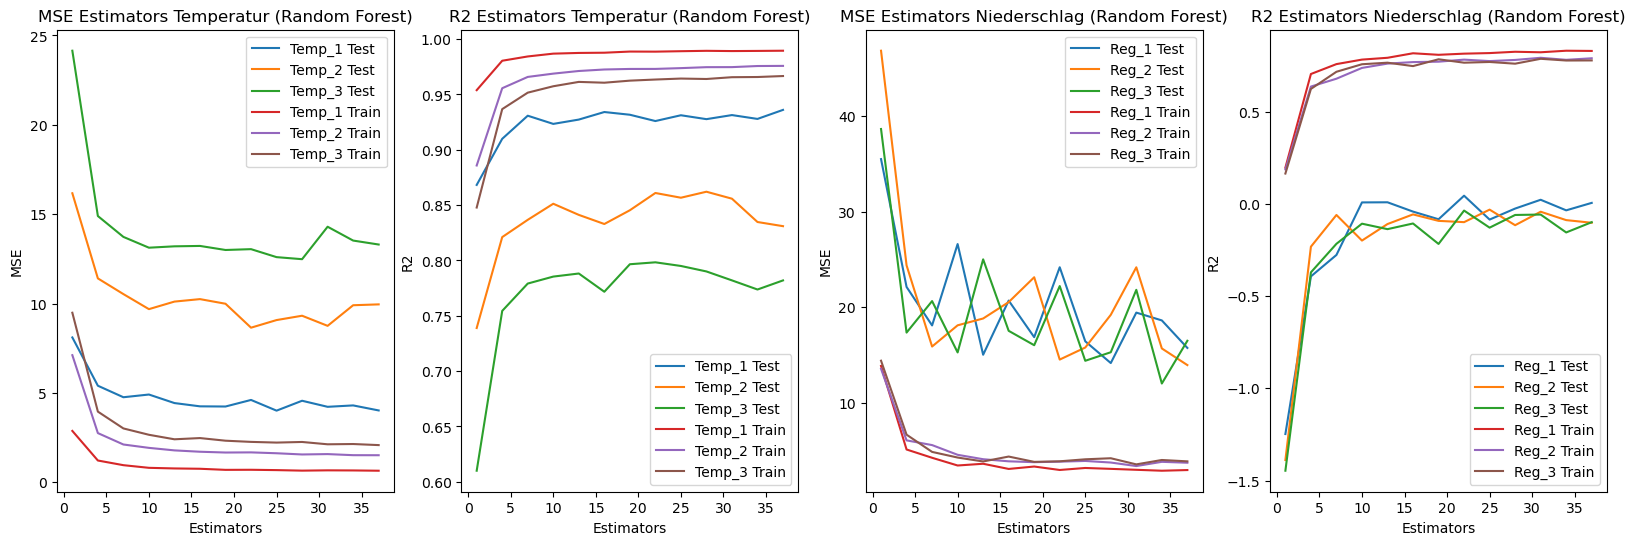

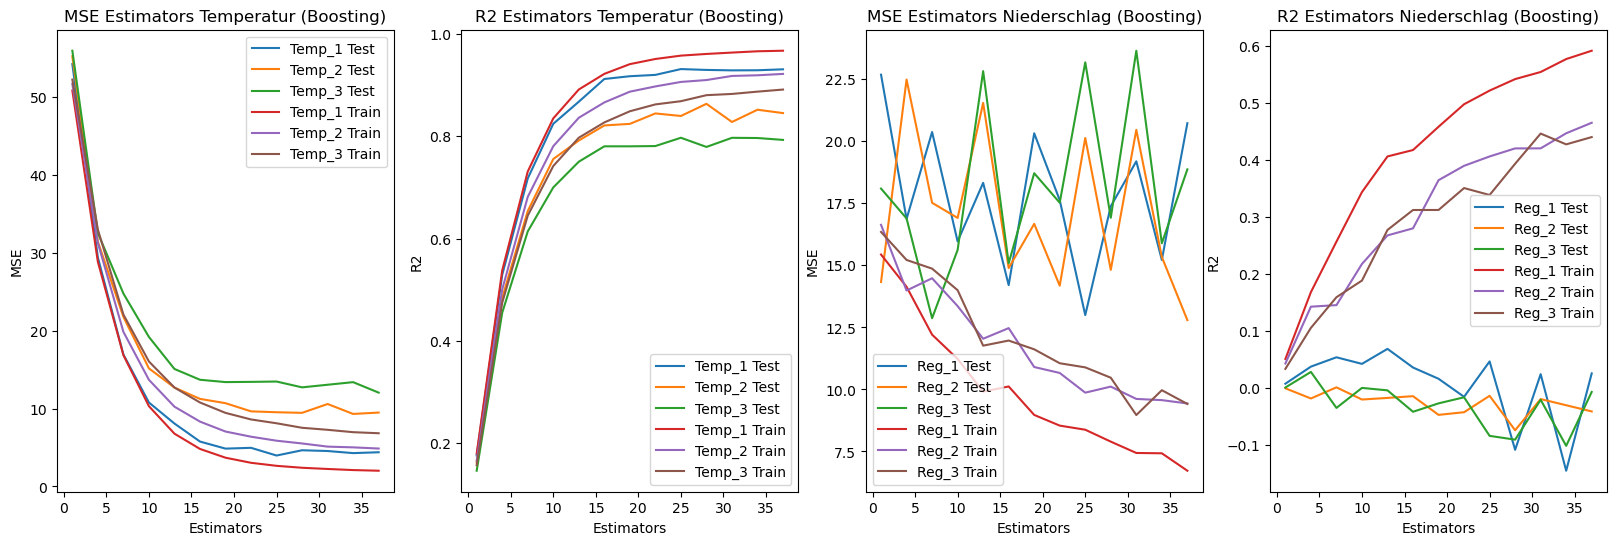

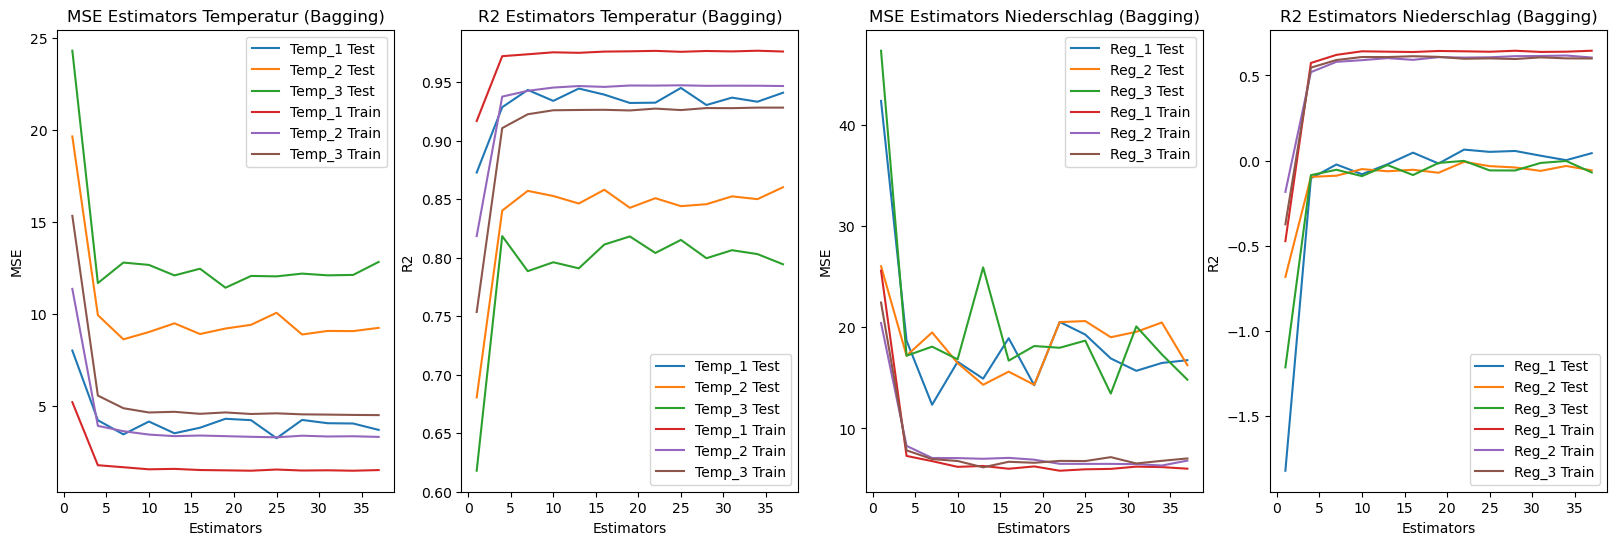

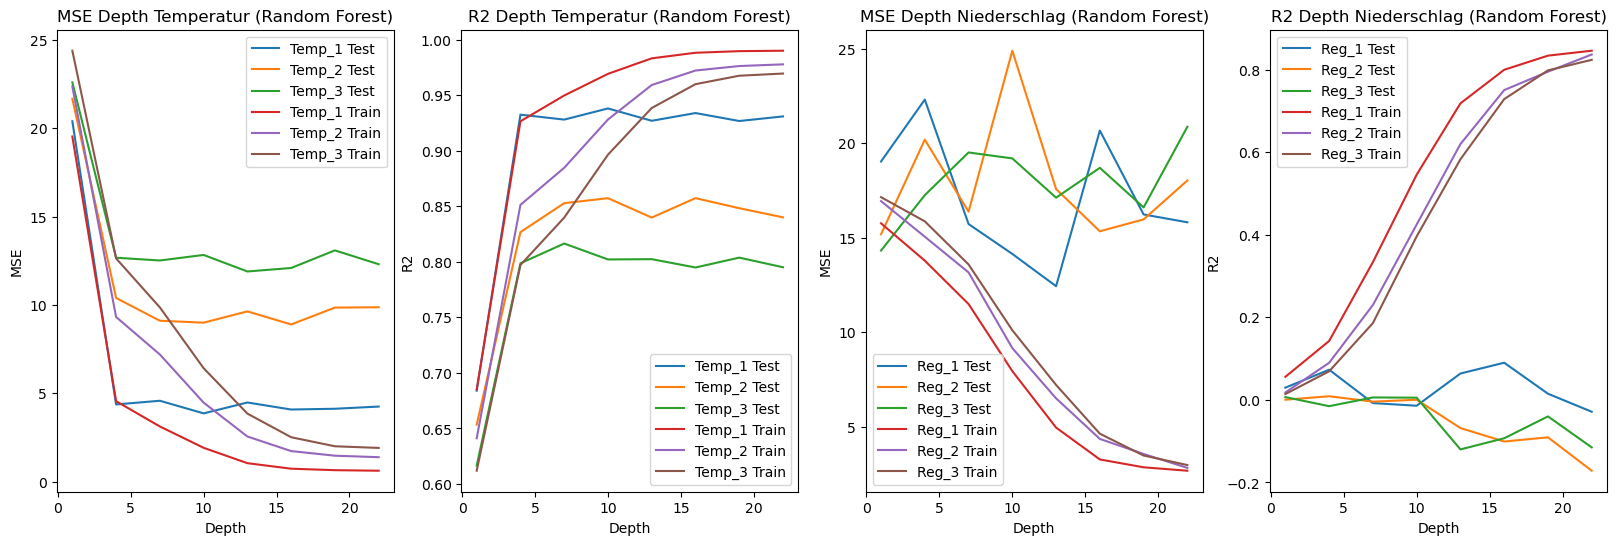

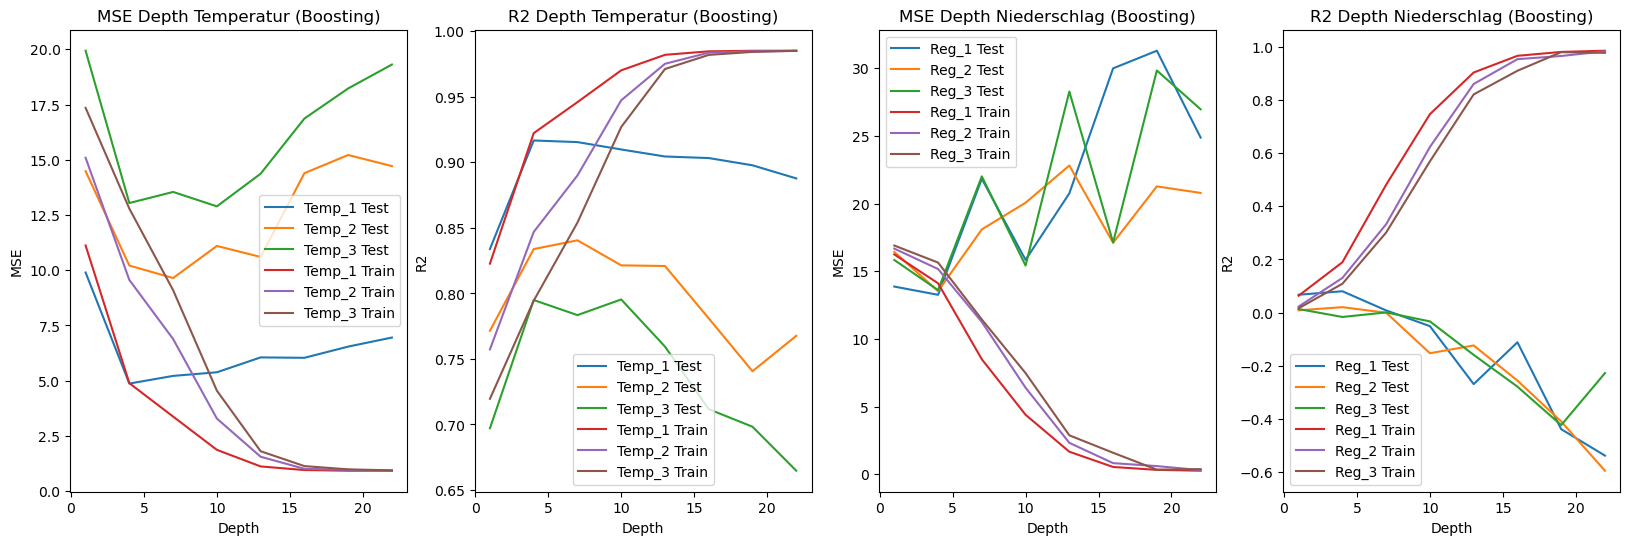

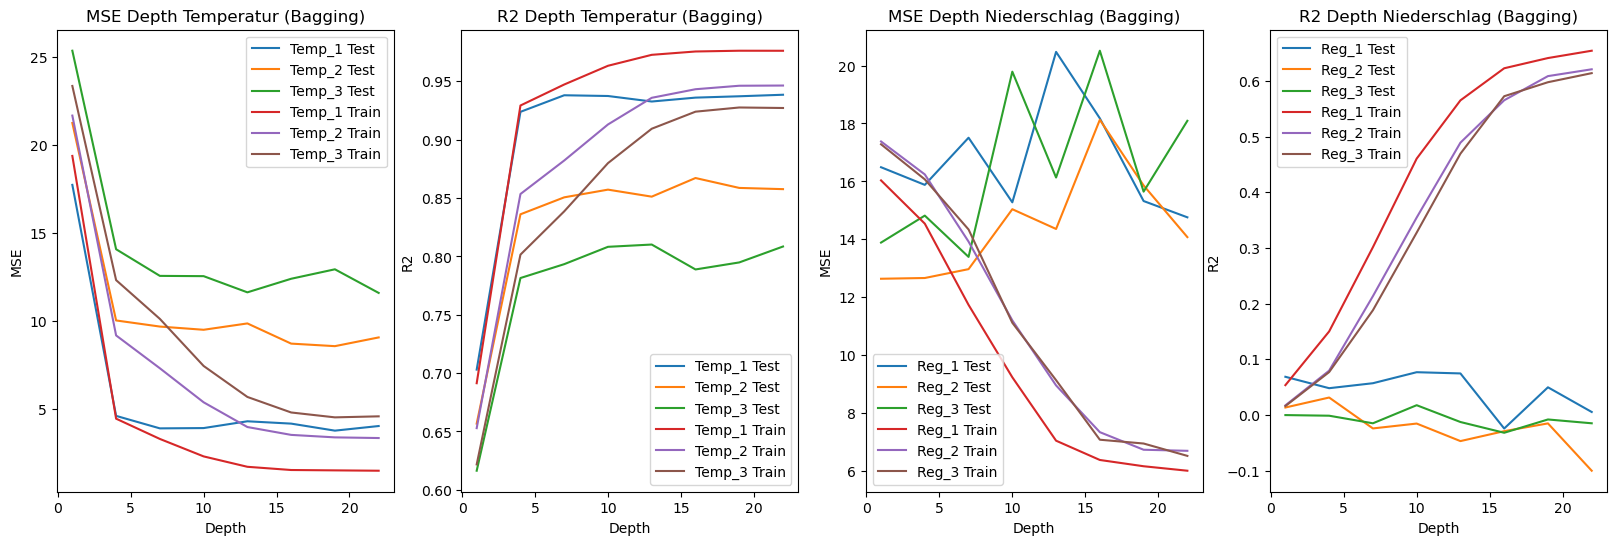

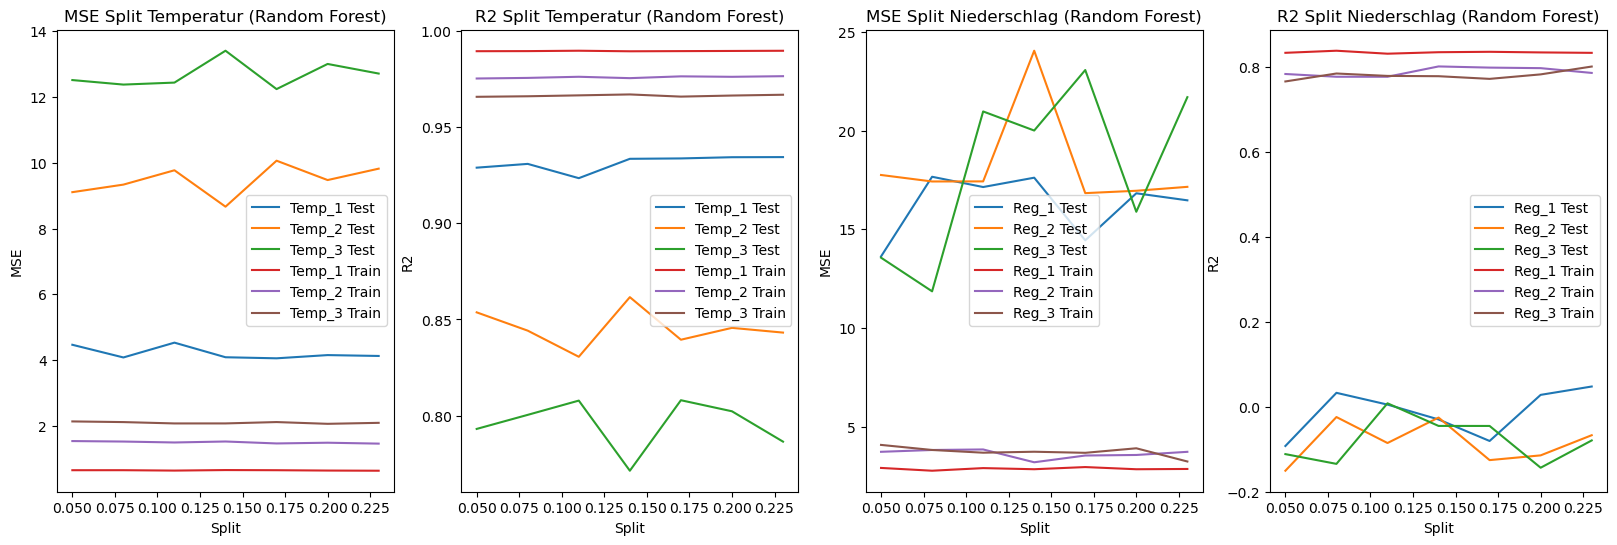

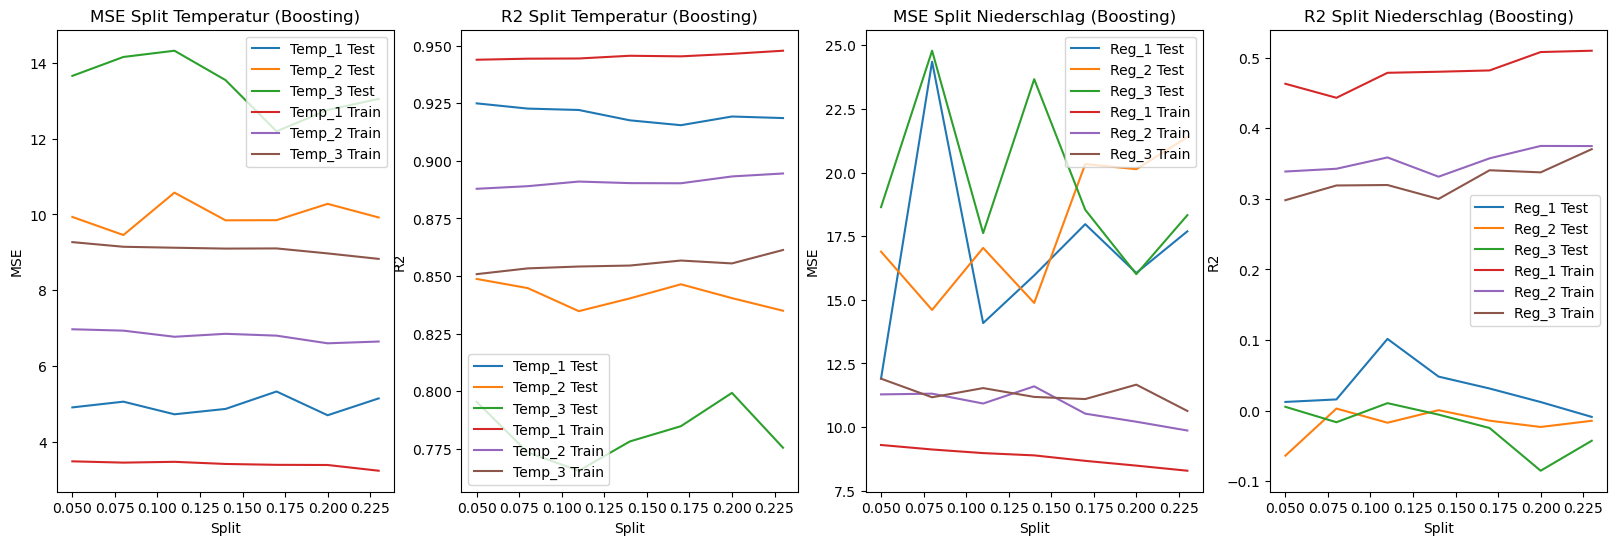

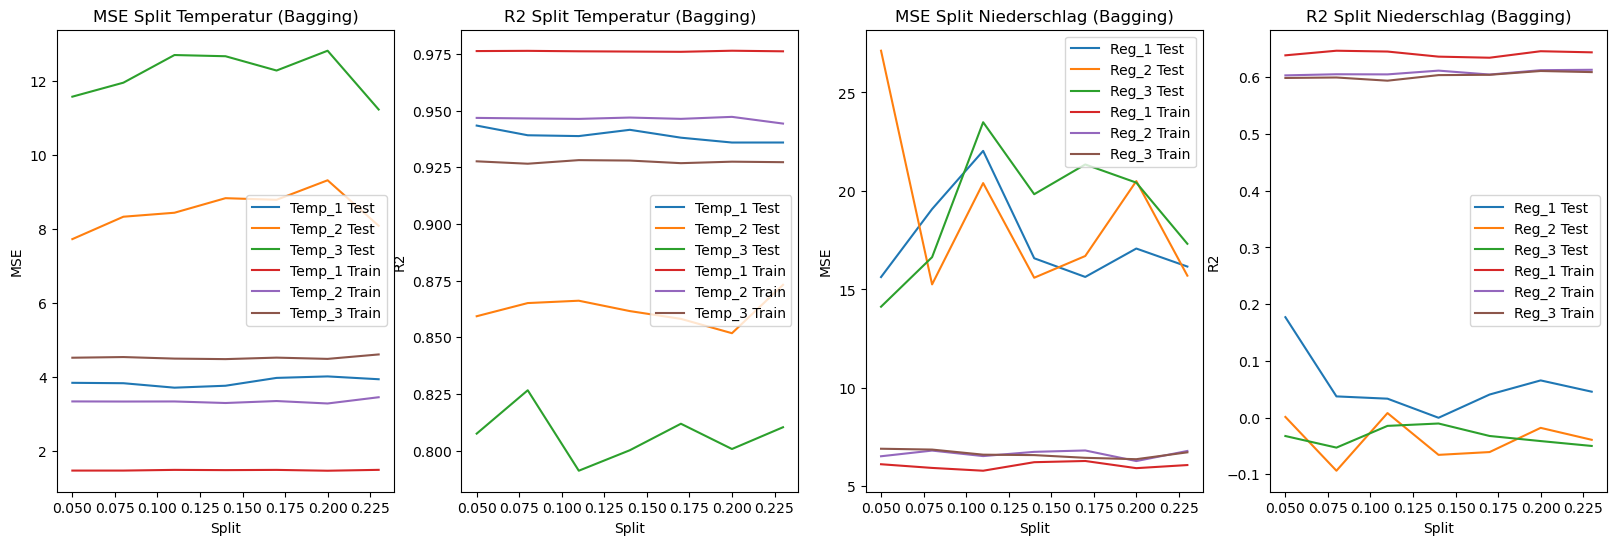

In [8]:
for df, var_name, f_var_name in [(estimatorsCollection, "Estimators", "estimator"), (depthCollection, "Depth", "depth"), (splitCollection, "Split", "split")]:
    for name, sname, fname in zip(["Random Forest", "Boosting", "Bagging"], ["RF", "GB", "BG"], ["forest", "boosting", "bagging"]):
        fig, axs = plt.subplots(1, 4, figsize=(20, 6))
        for i, type, tname, method, method_name in [(0, "mse", "MSE", "Temp", "Temperatur"), (1, "r2", "R2", "Temp", "Temperatur"), (2, "mse", "MSE", "Reg", "Niederschlag"), (3, "r2", "R2", "Reg", "Niederschlag")]:
            df.plot(x="Key", y=[f"{method}_{day}_{type}_{dat}_{sname}" for dat in ["test", "train"] for day in range(1, 4, 1)], ax=axs[i])
            axs[i].set_ylabel(f'{tname}')
            axs[i].set_xlabel(f'{var_name}')
            axs[i].set_title(f'{tname} {var_name} {method_name} ({name})')
            axs[i].legend([f"{method}_{day} {dat}" for dat in ["Test", "Train"] for day in range(1, 4, 1)])
        
        plt.savefig(f'{f_var_name}_variation_{fname}.png')
        plt.show()

## Finden der Besten parameter für die einzelnen Modelle
Hier werden jetzt die besten Parameter aus den zuvor geplotteten vergleichsdaten herrausgearbeitet.

In [9]:
#Besten werte finden
best_values = {
    "estimator": {
        "RF": [],
        "GB": [],
        "BG": []
    },
    "depth": {
        "RF": [],
        "GB": [],
        "BG": []
    },
    "split": {
        "RF": [],
        "GB": [],
        "BG": []
    }
}
for df, var_name, f_var_name in [(estimatorsCollection, "Estimators", "estimator"), (depthCollection, "Depth", "depth"), (splitCollection, "Split", "split")]:
    for name, sname, fname in zip(["Random Forest", "Boosting", "Bagging"], ["RF", "GB", "BG"], ["forest", "boosting", "bagging"]):
        for i, type, tname, method, method_name in [(0, "mse", "MSE", "Temp", "Temperatur"), (1, "r2", "R2", "Temp", "Temperatur"), (2, "mse", "MSE", "Reg", "Niederschlag"), (3, "r2", "R2", "Reg", "Niederschlag")]:
            for day in range(1, 4, 1):
                if type == "mse":
                    best_values[f_var_name][sname].append(df.loc[df[f"{method}_{day}_{type}_test_{sname}"].idxmin()]["Key"])
                else:
                    best_values[f_var_name][sname].append(df.loc[(df[f"{method}_{day}_{type}_test_{sname}"] - 1).abs().idxmin()]["Key"])

for type in ["estimator", "depth", "split"]:
    for method in ["RF", "GB", "BG"]:
        liste = best_values[type][method]
        best_values[f'{type}_{method}_avg'] = round(sum(liste) / len(liste), 2)
        print(type, method, best_values[f'{type}_{method}_avg'])

estimator RF 27.5
estimator GB 22.25
estimator BG 19.75
depth RF 9.0
depth GB 5.25
depth BG 13.75
split RF 0.15
split GB 0.12
split BG 0.1


## Vergleich der einzlenen Modelle
Hier werden jetzt die einzelnen Modelle auf den besten parametern ausgewertet.

In [10]:
# Einzelnen Methoden Vergleichen
best_scores = {}

for target in ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]:
    print(target)
    y_test, y_pred_test, y_train, y_pred_train, reg = randomForest(X_Val, globals()[f"Y_{target}"], round(best_values[f'estimator_RF_avg']), round(best_values[f'depth_RF_avg']), best_values[f'split_RF_avg'])
    best_scores[f"{target}_mse_RF"] = math.sqrt(mean_squared_error(y_test, y_pred_test))
    best_scores[f"{target}_r2_RF"] = r2_score(y_test, y_pred_test)
    best_scores[f"{target}_dat_RF"] = (y_test, y_pred_test)
    print("Random Forest", "RMSE", best_scores[f"{target}_mse_RF"])
    print("Random Forest", "R2", best_scores[f"{target}_r2_RF"])
    print()
    
    y_test, y_pred_test, y_train, y_pred_train, reg = boosting(X_Val, globals()[f"Y_{target}"], round(best_values[f'estimator_GB_avg']), round(best_values[f'depth_GB_avg']), best_values[f'split_GB_avg'])
    best_scores[f"{target}_mse_GB"] = math.sqrt(mean_squared_error(y_test, y_pred_test))
    best_scores[f"{target}_r2_GB"] = r2_score(y_test, y_pred_test)
    best_scores[f"{target}_dat_GB"] = (y_test, y_pred_test)
    print("Boosting", "RMSE", best_scores[f"{target}_mse_GB"])
    print("Boosting", "R2", best_scores[f"{target}_r2_GB"])
    print()
    
    y_test, y_pred_test, y_train, y_pred_train, reg = bagging(X_Val, globals()[f"Y_{target}"], round(best_values[f'estimator_BG_avg']), round(best_values[f'depth_BG_avg']), best_values[f'split_BG_avg'])
    best_scores[f"{target}_mse_BG"] = math.sqrt(mean_squared_error(y_test, y_pred_test))
    best_scores[f"{target}_r2_BG"] = r2_score(y_test, y_pred_test)
    best_scores[f"{target}_dat_BG"] = (y_test, y_pred_test)
    print("Bagging", "RMSE", best_scores[f"{target}_mse_BG"])
    print("Bagging", "R2", best_scores[f"{target}_r2_BG"])
    print()



Temp_1
Random Forest RMSE 1.9876915435679012
Random Forest R2 0.9369262502471988

Boosting RMSE 2.094570070618481
Boosting R2 0.9282995386653232

Bagging RMSE 1.9512242091673
Bagging R2 0.9327766836151552

Temp_2
Random Forest RMSE 3.0416999331082586
Random Forest R2 0.8604077363039111

Boosting RMSE 3.172265946774372
Boosting R2 0.8329930874497492

Bagging RMSE 2.9335331912866995
Bagging R2 0.8593174723531294

Temp_3
Random Forest RMSE 3.4544719830925508
Random Forest R2 0.8070342840580542

Boosting RMSE 3.608470492683922
Boosting R2 0.7845173804198473

Bagging RMSE 3.4995437905648266
Bagging R2 0.8088859362911608

Reg_1
Random Forest RMSE 3.7765458610871634
Random Forest R2 0.05619944090975004

Boosting RMSE 4.230742291890201
Boosting R2 0.06025094686260535

Bagging RMSE 4.445969774509782
Bagging R2 0.07744449188474789

Reg_2
Random Forest RMSE 4.0417142571136795
Random Forest R2 0.0017993970379095447

Boosting RMSE 4.498048028388668
Boosting R2 0.010081163758944967

Bagging RMSE 4.2

### Jetzt werden die Modelle miteinander verglichen

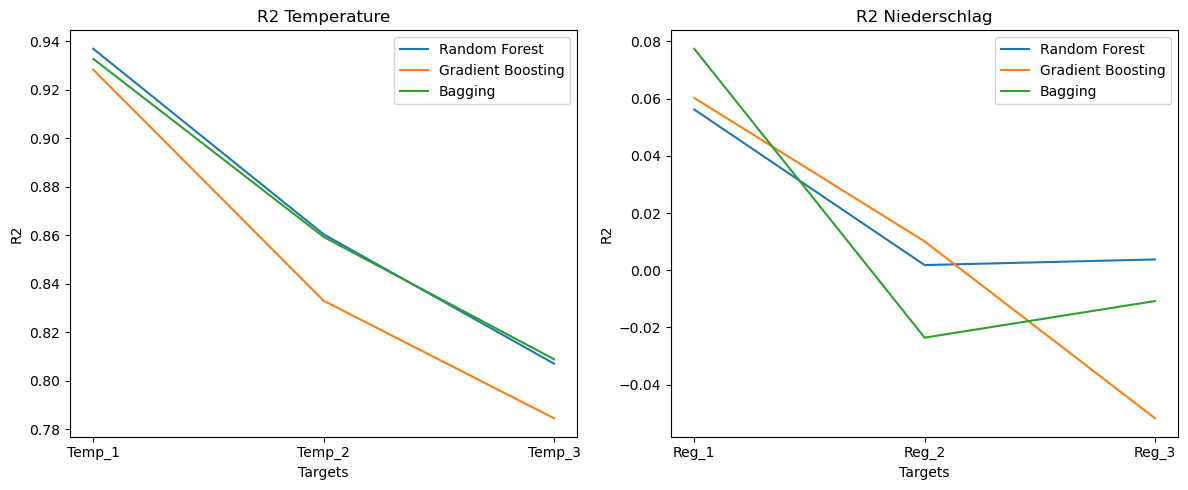

In [14]:
# Daten für den ersten Plot
targets_temp = ["Temp_1", "Temp_2", "Temp_3"]
mse_RF_temp = [best_scores[f'{target}_r2_RF'] for target in targets_temp]
mse_GB_temp = [best_scores[f'{target}_r2_GB'] for target in targets_temp]
mse_BG_temp = [best_scores[f'{target}_r2_BG'] for target in targets_temp]

# Daten für den zweiten Plot
targets_reg = ["Reg_1", "Reg_2", "Reg_3"]
mse_RF_reg = [best_scores[f'{target}_r2_RF'] for target in targets_reg]
mse_GB_reg = [best_scores[f'{target}_r2_GB'] for target in targets_reg]
mse_BG_reg = [best_scores[f'{target}_r2_BG'] for target in targets_reg]

# Subplots erstellen
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Erster Plot (Temperatur)
axs[0].plot(targets_temp, mse_RF_temp, label='Random Forest')
axs[0].plot(targets_temp, mse_GB_temp, label='Gradient Boosting')
axs[0].plot(targets_temp, mse_BG_temp, label='Bagging')
axs[0].set_xlabel('Targets')
axs[0].set_ylabel('R2')
axs[0].set_title('R2 Temperature')
axs[0].legend()

# Zweiter Plot (Niederschlag)
axs[1].plot(targets_reg, mse_RF_reg, label='Random Forest')
axs[1].plot(targets_reg, mse_GB_reg, label='Gradient Boosting')
axs[1].plot(targets_reg, mse_BG_reg, label='Bagging')
axs[1].set_xlabel('Targets')
axs[1].set_ylabel('R2')
axs[1].set_title('R2 Niederschlag')
axs[1].legend()

# Subplots anzeigen
plt.tight_layout()
plt.savefig(f'compare_mse_methods.png')
plt.show()

## Auswertung der Modelle im vergleich zu den Gemessenen Daten
Hier werden jetzt die Predictions mit den gemessenen soll daten verglichen und ins verhältnis gesätzt.

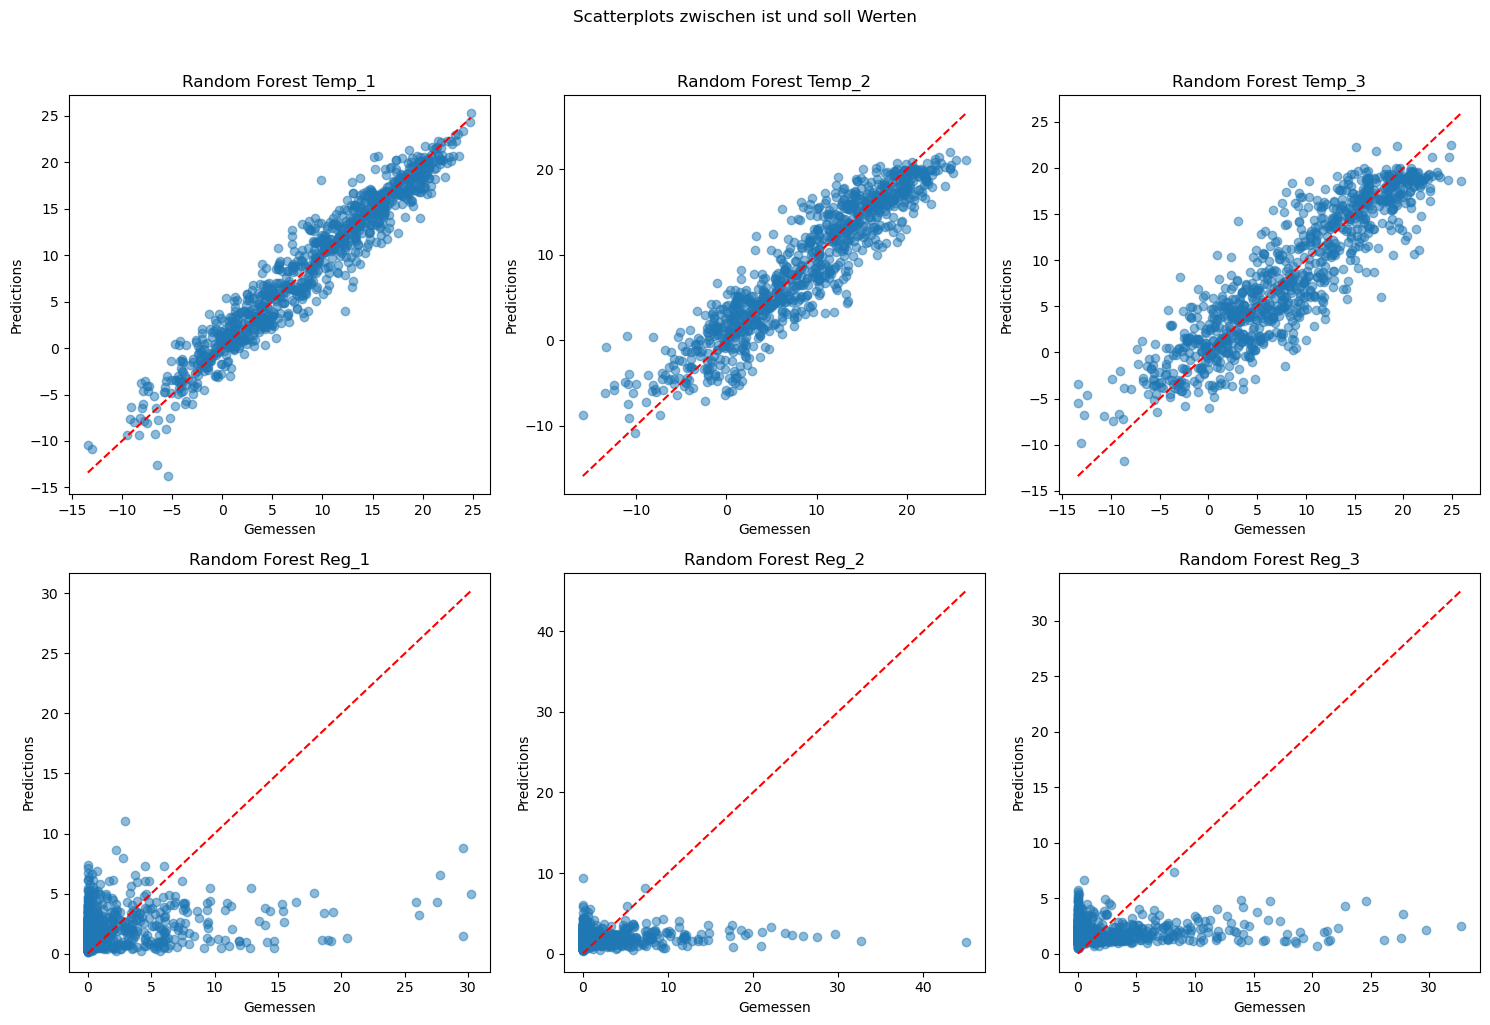

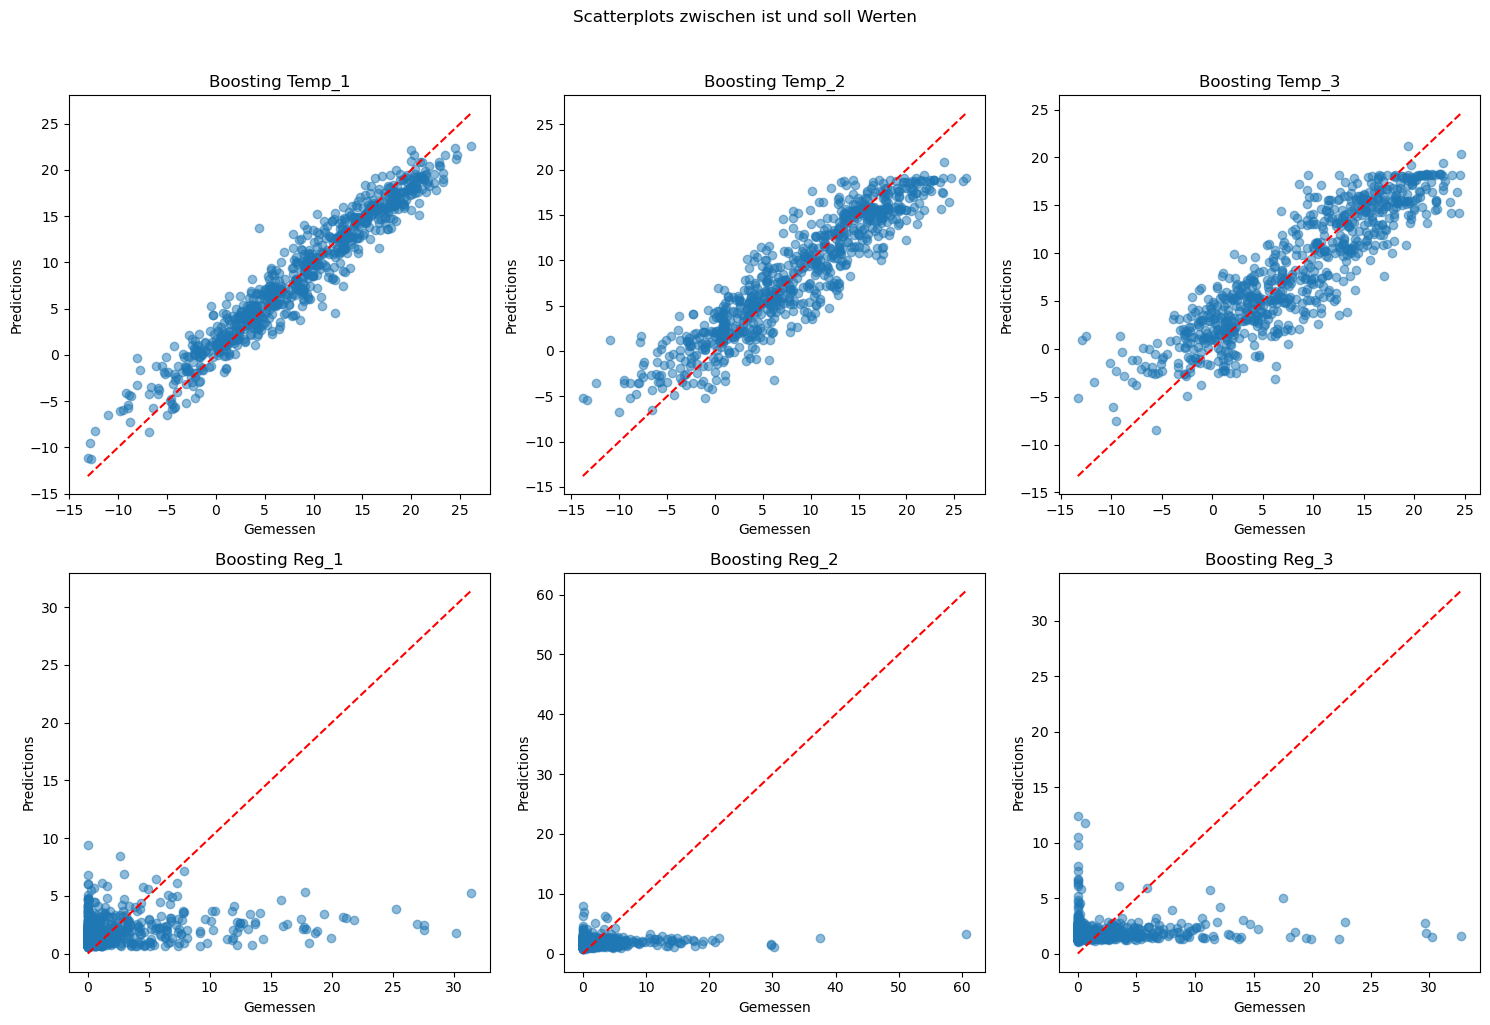

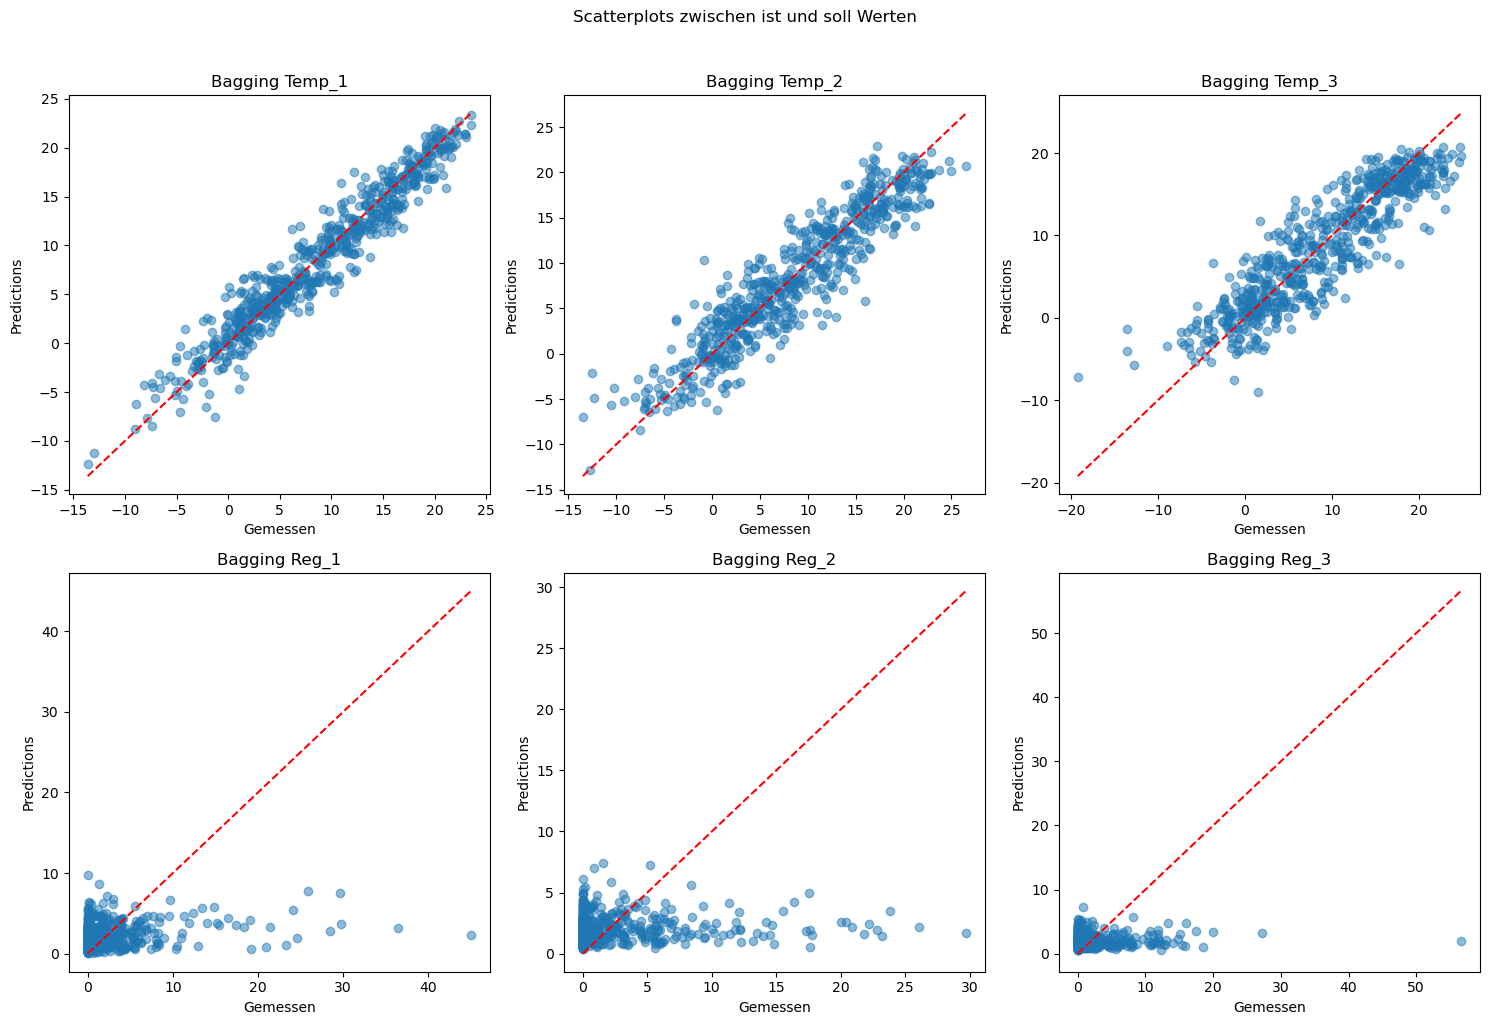

In [12]:
# Subplots erstellen
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Scatterplots zwischen ist und soll Werten', y=1.02)

# Iteriere über die Zielvariablen und plotte in den entsprechenden Subplots
for i, target in enumerate(["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]):
    y_test, y_pred_test = best_scores[f"{target}_dat_RF"]
    row = i // 3
    col = i % 3
    axes[row, col].scatter(y_test, y_pred_test, alpha=0.5)
    axes[row, col].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[row, col].set_title(f'Random Forest {target}')
    axes[row, col].set_xlabel('Gemessen')
    axes[row, col].set_ylabel('Predictions')

# Layout anpassen
plt.tight_layout()
plt.savefig(f'relation_RF.png')
plt.show()

# Subplots erstellen
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Scatterplots zwischen ist und soll Werten', y=1.02)

# Iteriere über die Zielvariablen und plotte in den entsprechenden Subplots
for i, target in enumerate(["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]):
    y_test, y_pred_test = best_scores[f"{target}_dat_GB"]
    row = i // 3
    col = i % 3
    axes[row, col].scatter(y_test, y_pred_test, alpha=0.5)
    axes[row, col].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[row, col].set_title(f'Boosting {target}')
    axes[row, col].set_xlabel('Gemessen')
    axes[row, col].set_ylabel('Predictions')

# Layout anpassen
plt.tight_layout()
plt.savefig(f'relation_GB.png')
plt.show()

# Subplots erstellen
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle('Scatterplots zwischen ist und soll Werten', y=1.02)

# Iteriere über die Zielvariablen und plotte in den entsprechenden Subplots
for i, target in enumerate(["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]):
    y_test, y_pred_test = best_scores[f"{target}_dat_BG"]
    row = i // 3
    col = i % 3
    axes[row, col].scatter(y_test, y_pred_test, alpha=0.5)
    axes[row, col].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[row, col].set_title(f'Bagging {target}')
    axes[row, col].set_xlabel('Gemessen')
    axes[row, col].set_ylabel('Predictions')

# Layout anpassen
plt.tight_layout()
plt.savefig(f'relation_BG.png')
plt.show()

## Auswertung auf den Fit der Gemessenen Daten und Auswertung der Featcher Importance
Hier werden die einzelnen gemessenen Daten und die Prediction übereinander geplottet.
Zudem werden die Featcherimportance der Modelle geplottet.
Wichtig ist hier das die Plots der Featcherimportance logerithmisch dargestellt werden.

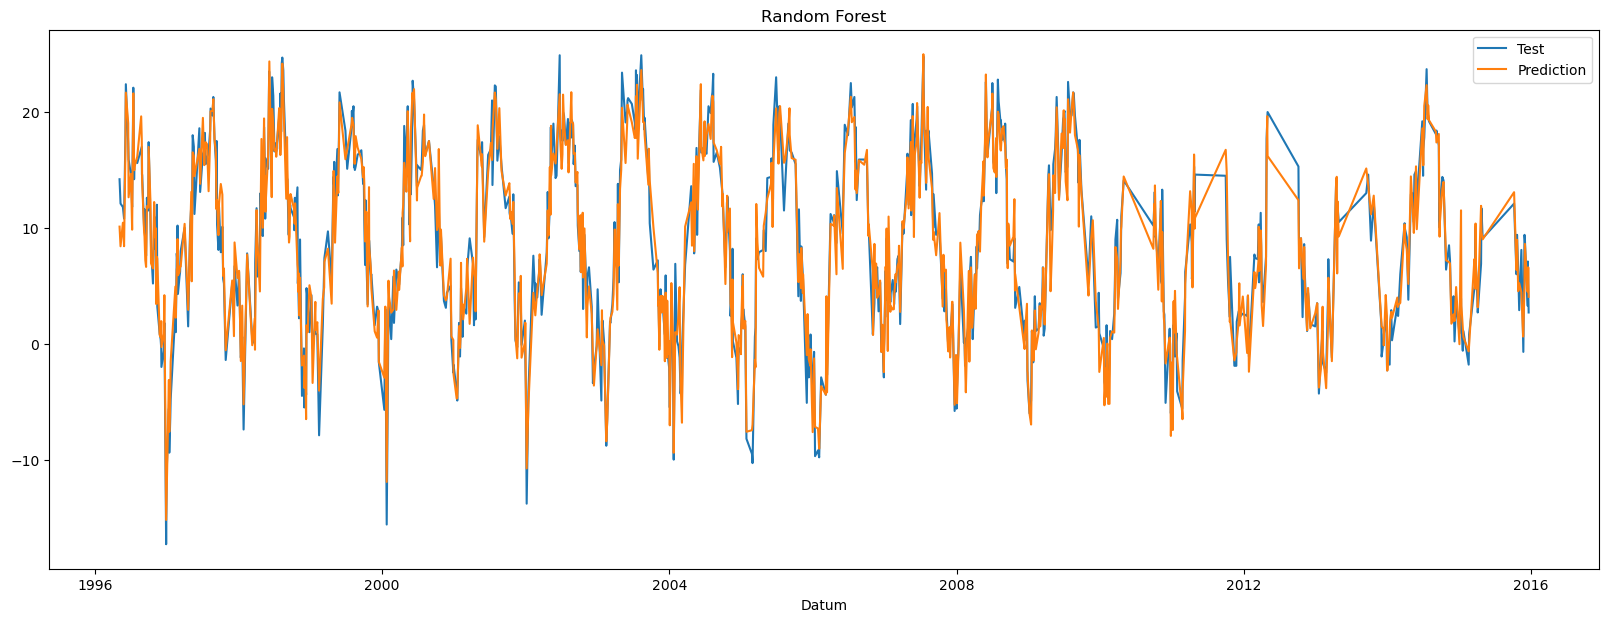

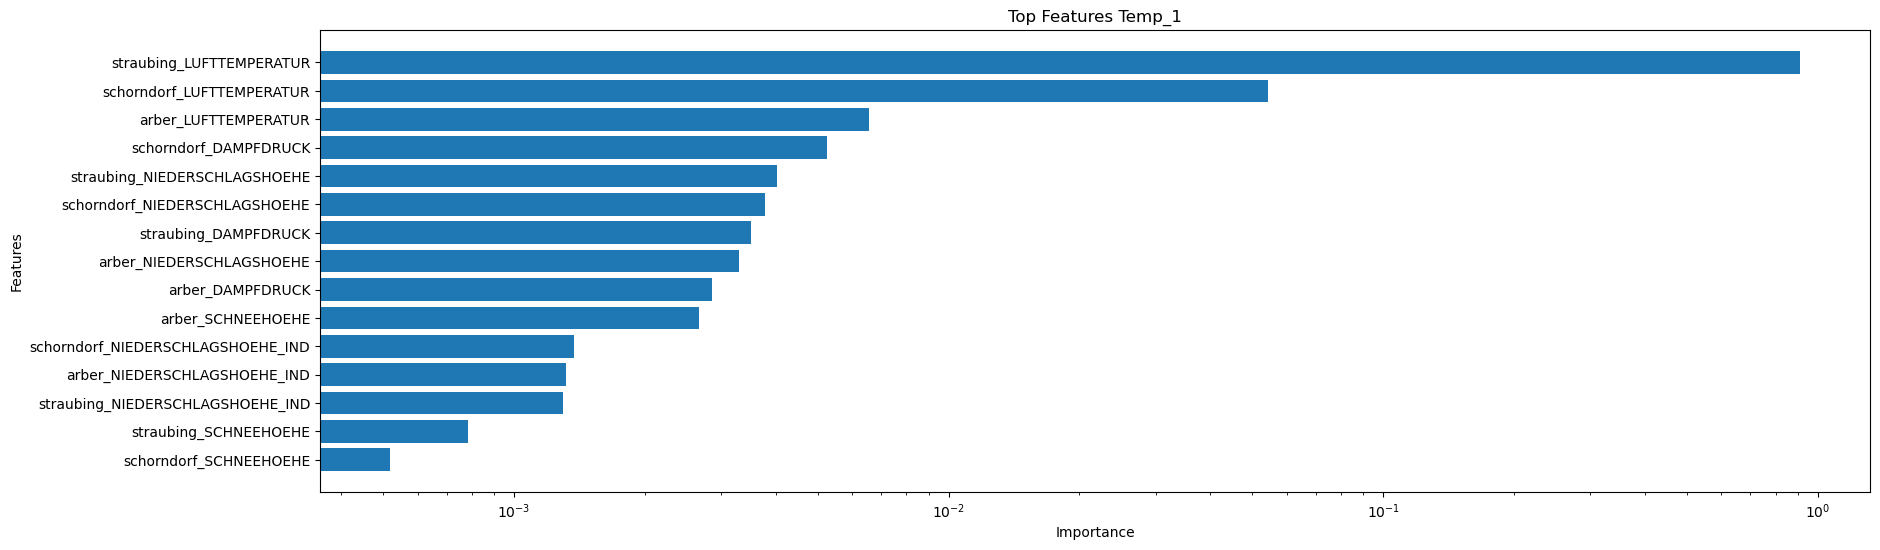

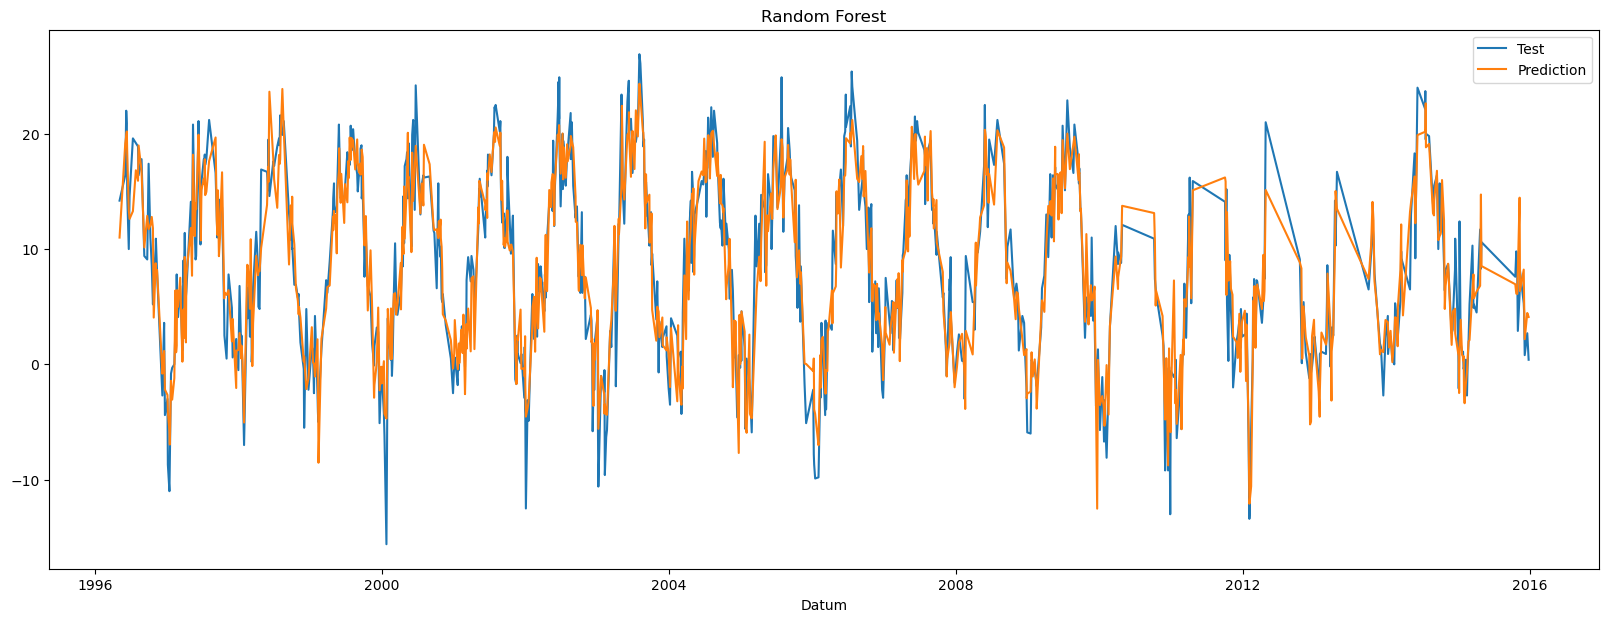

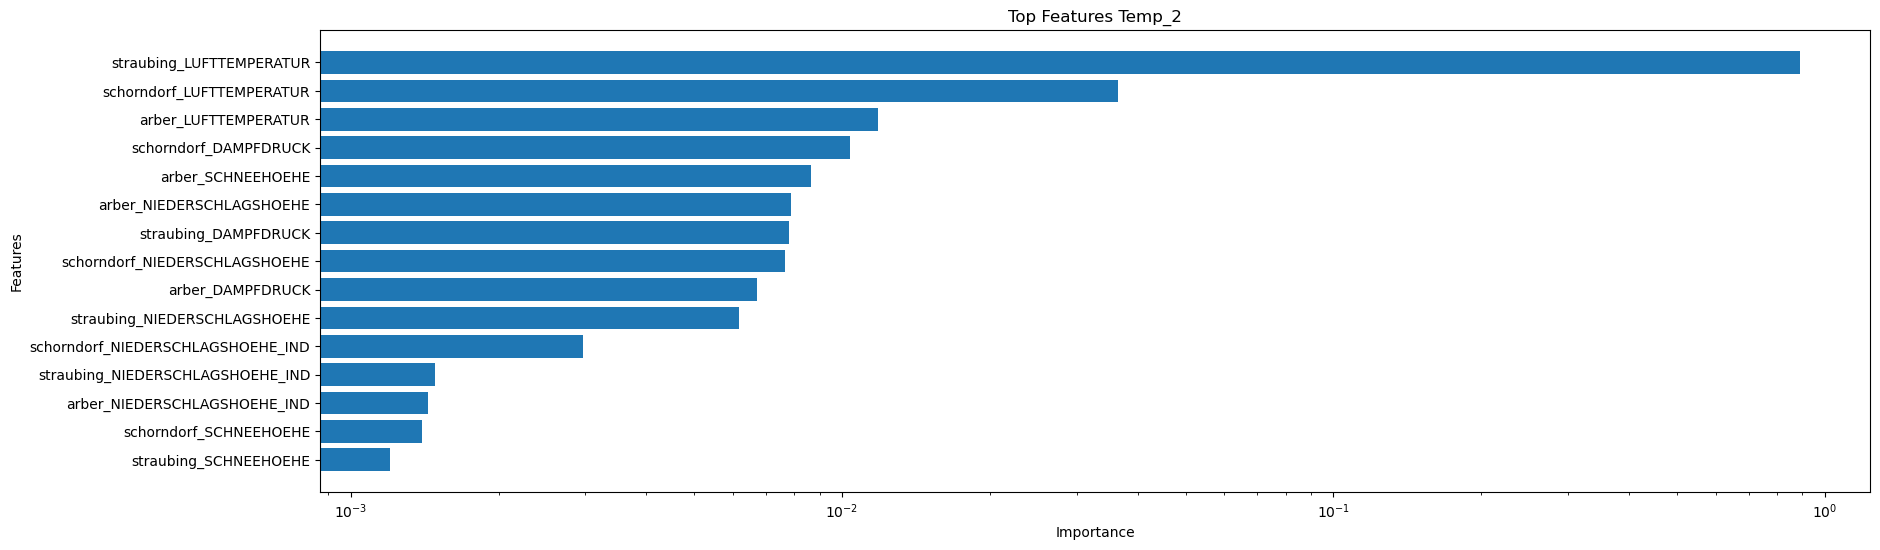

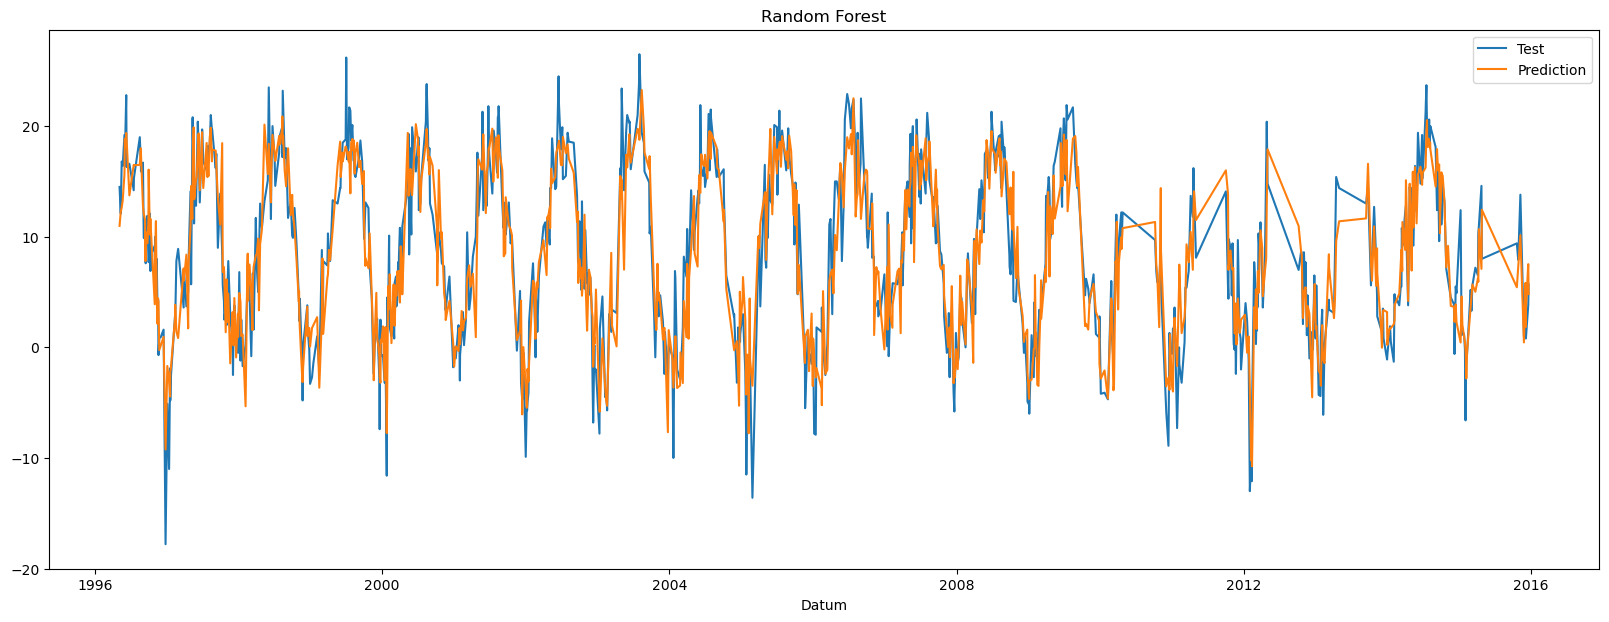

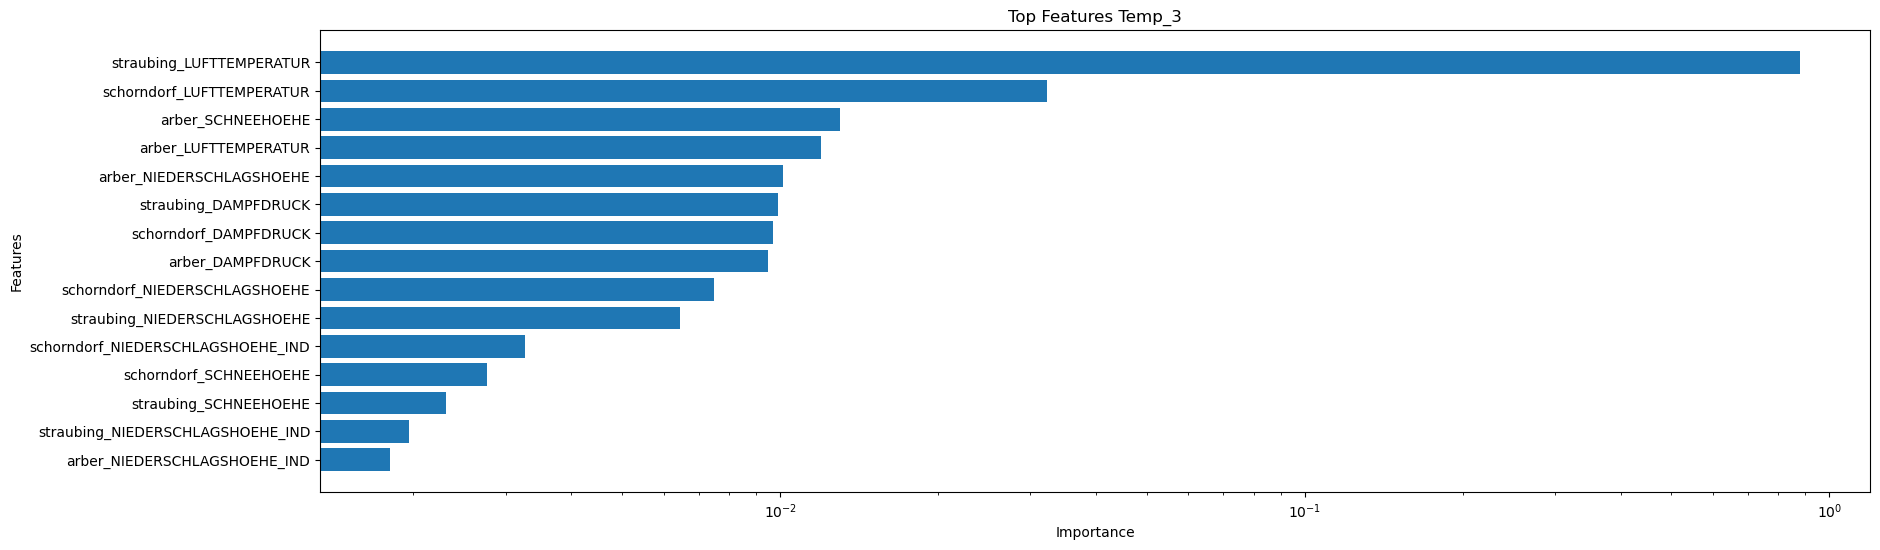

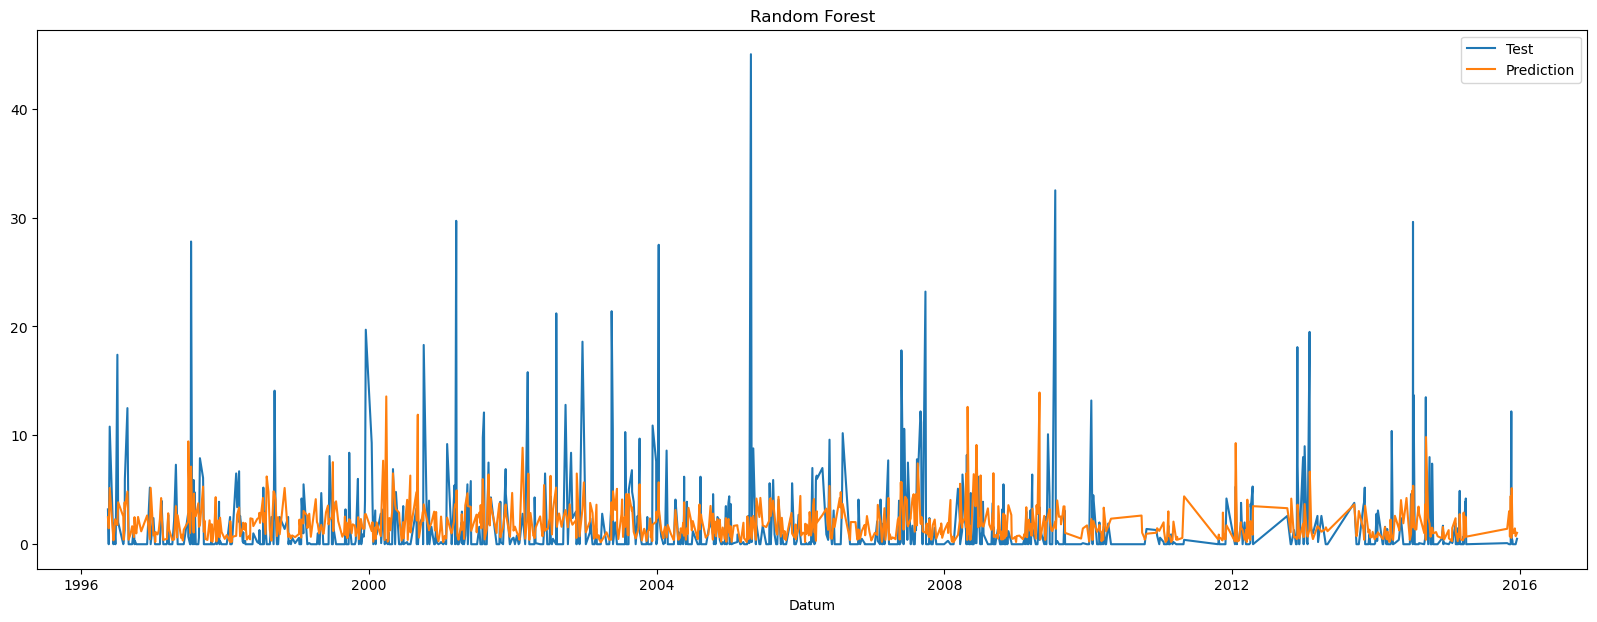

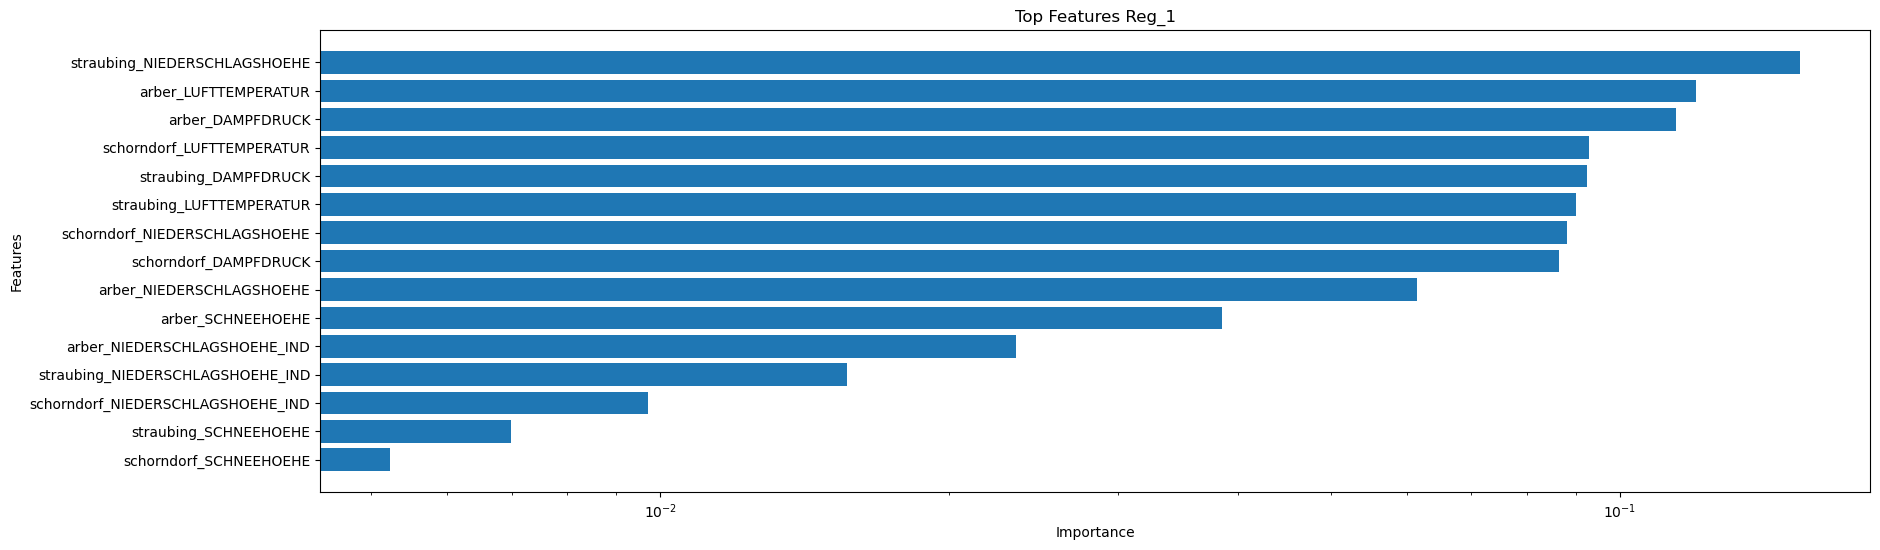

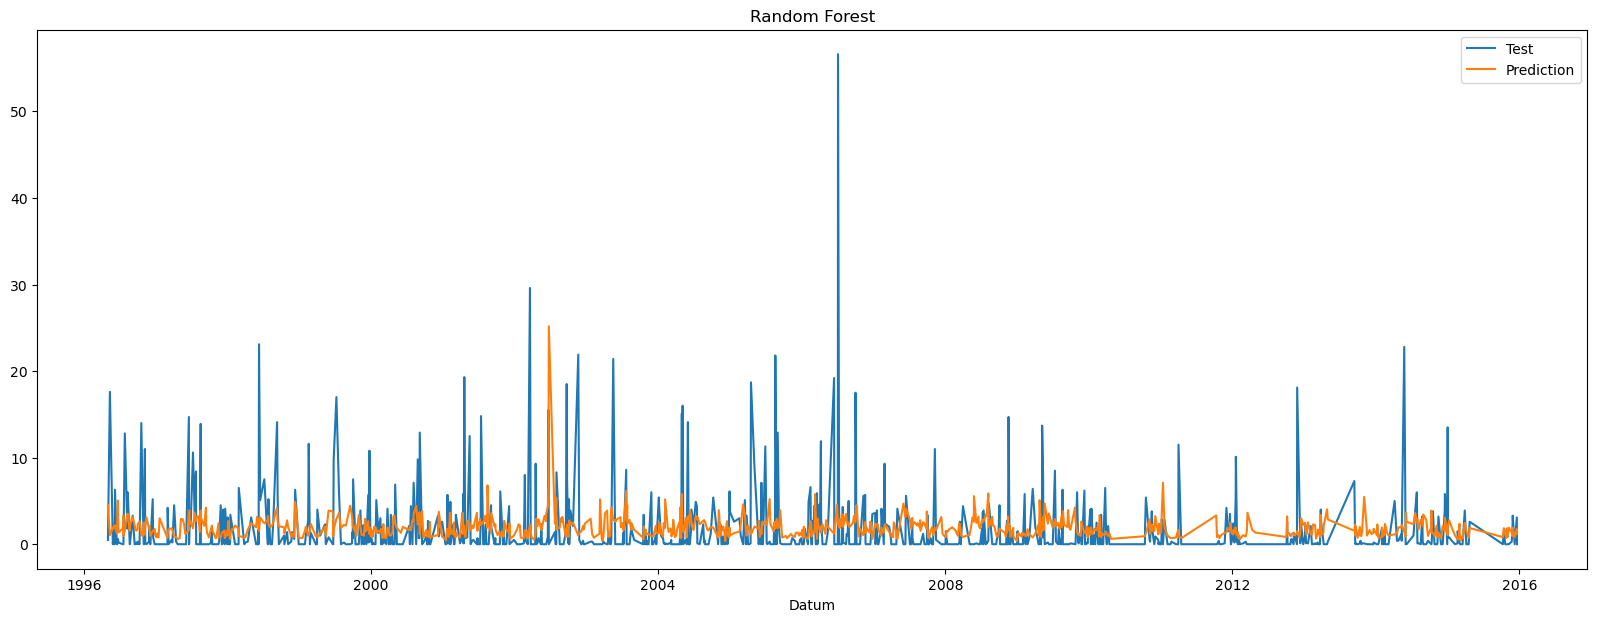

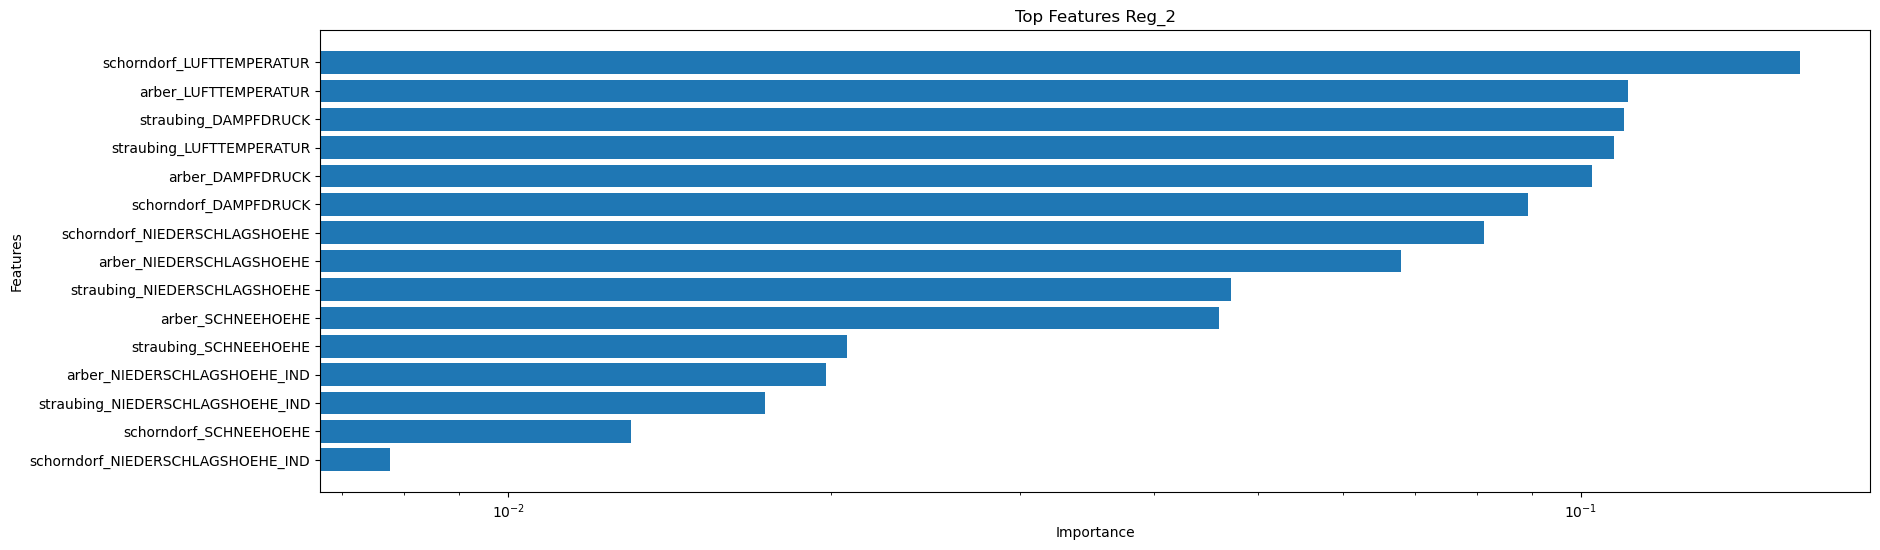

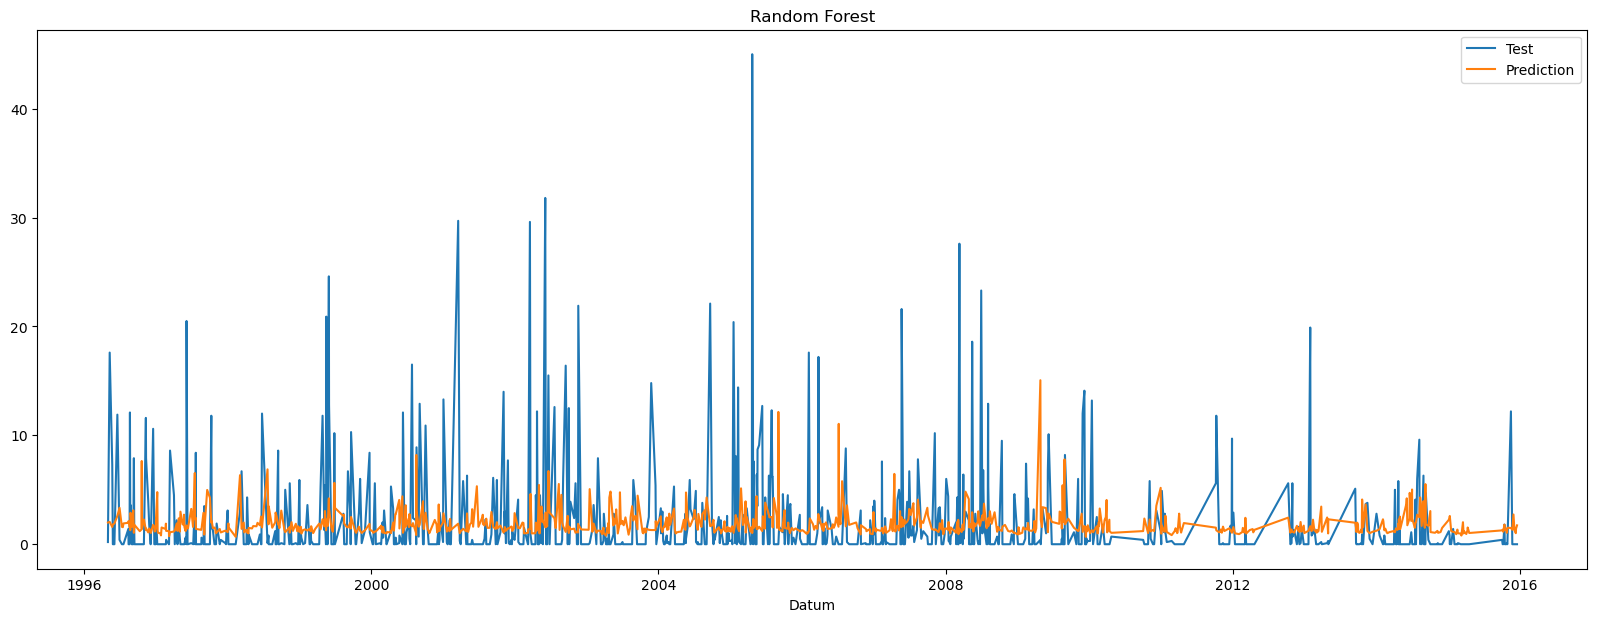

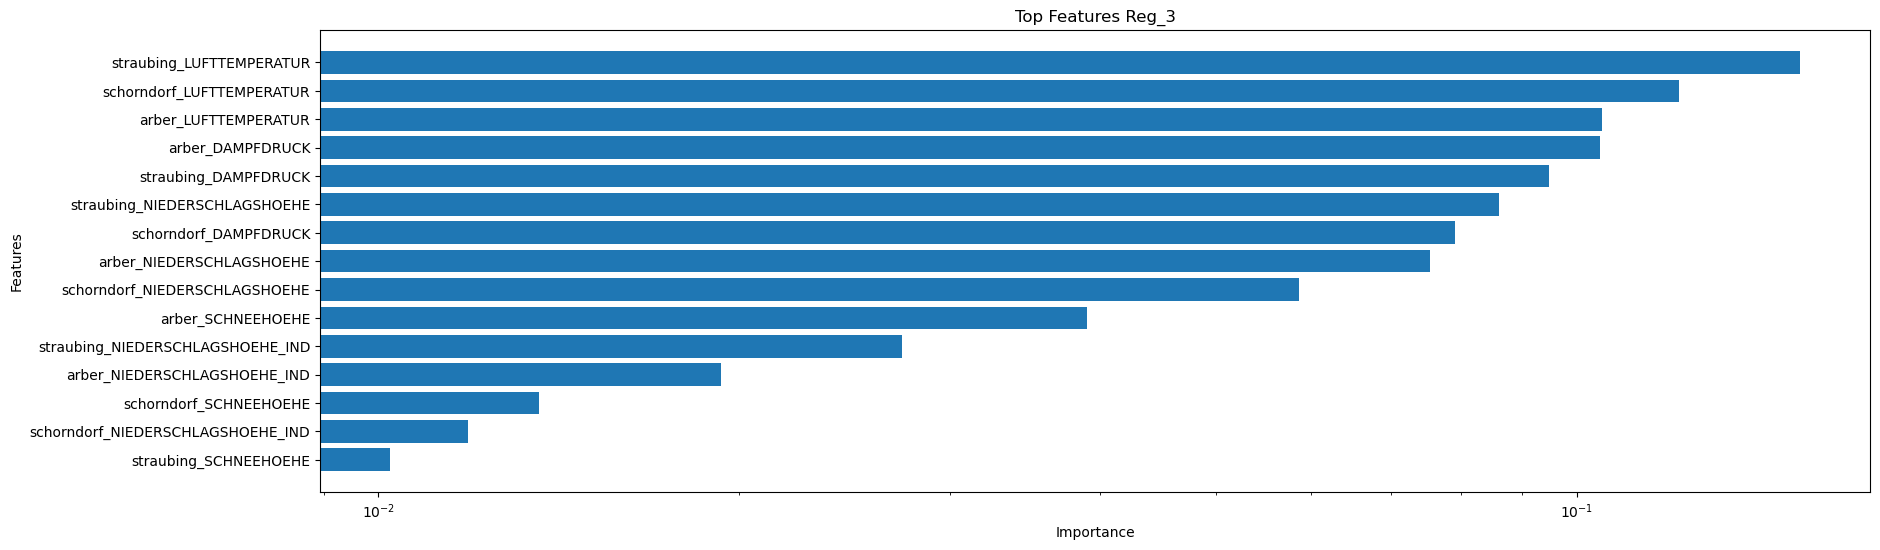

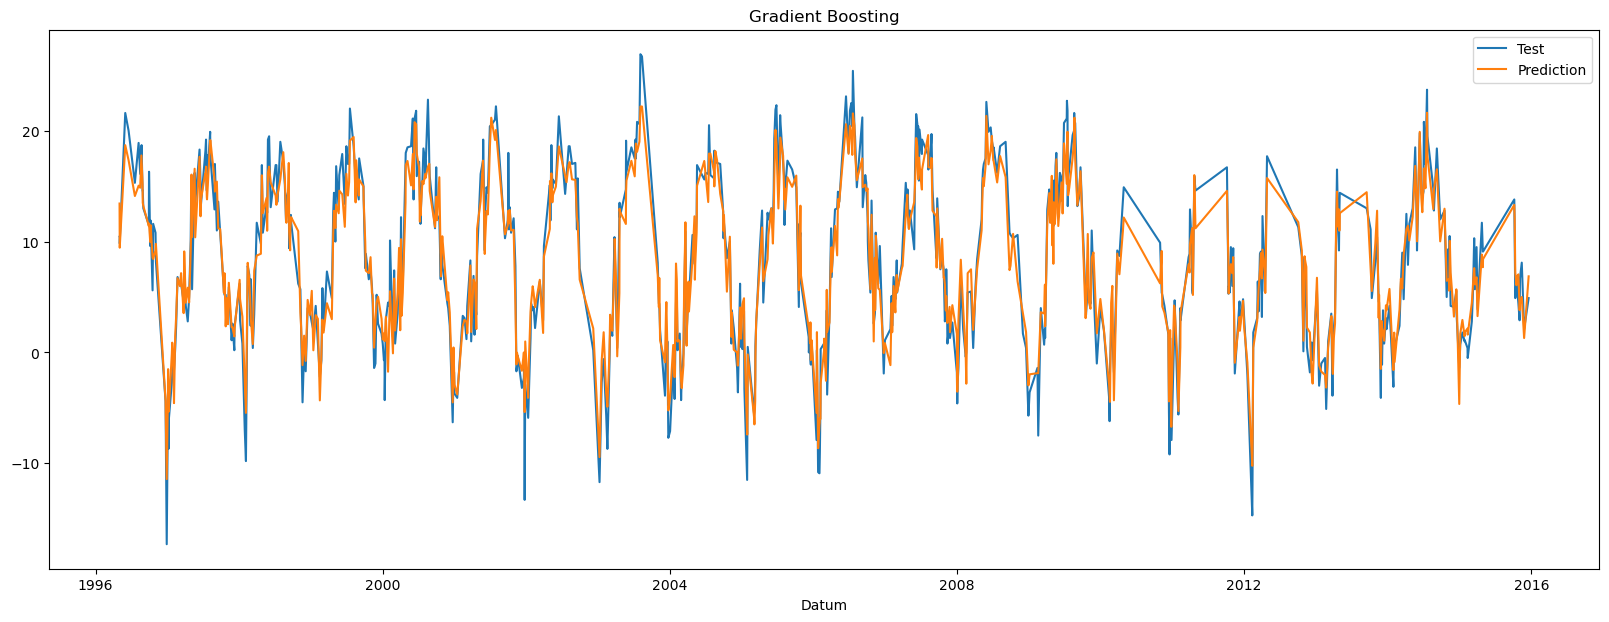

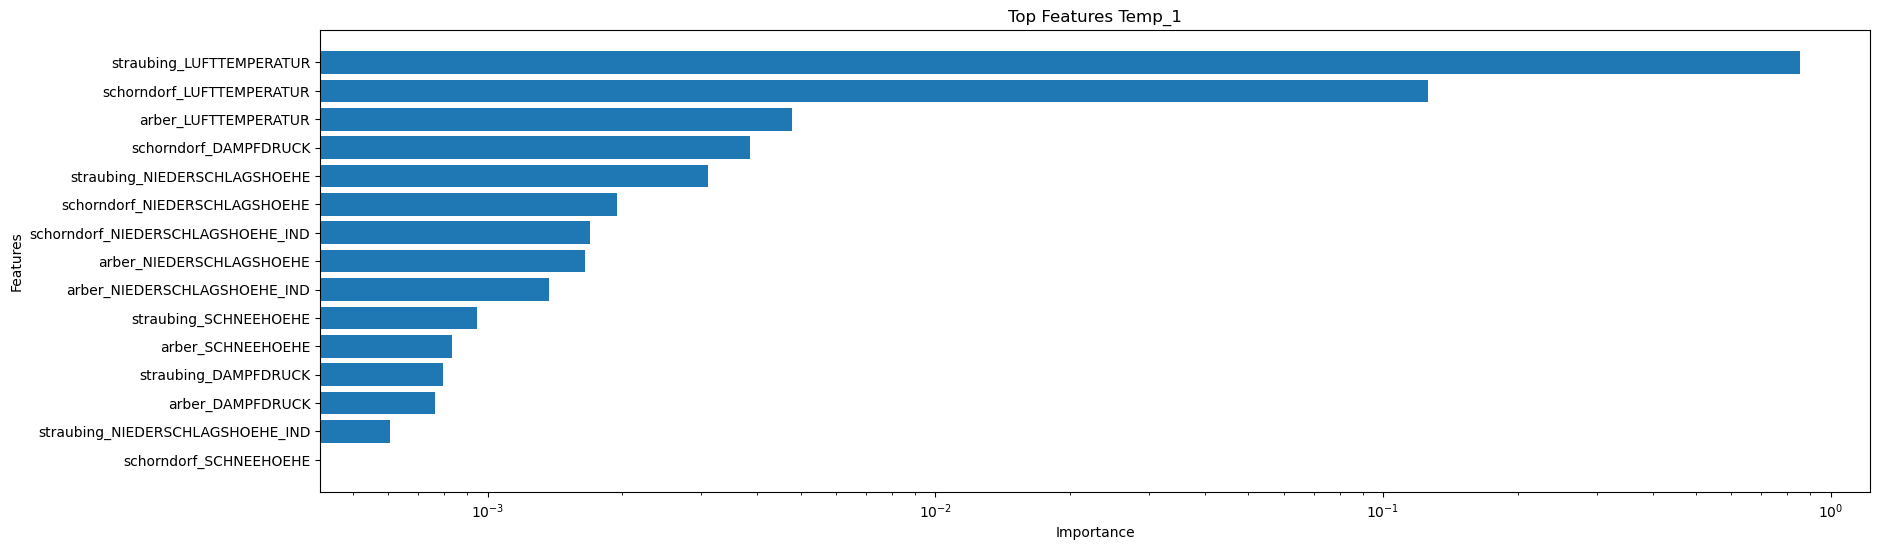

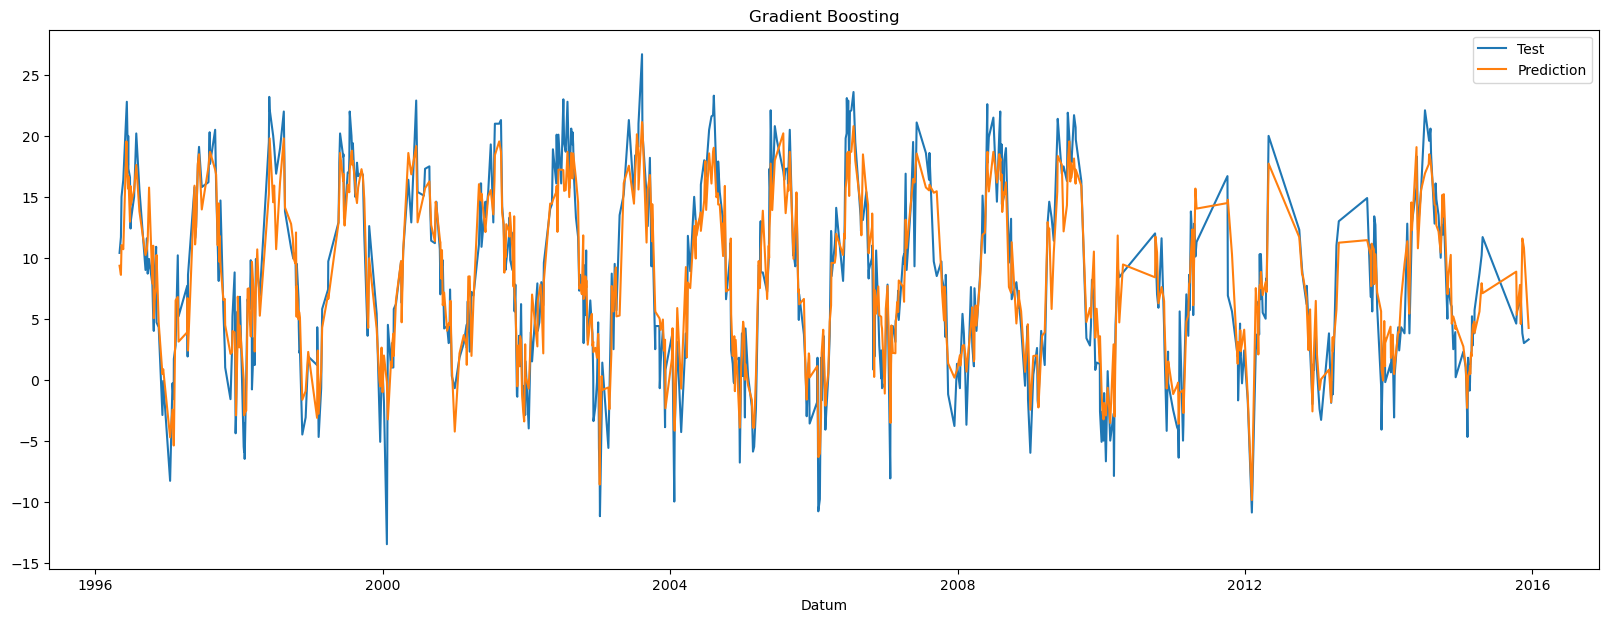

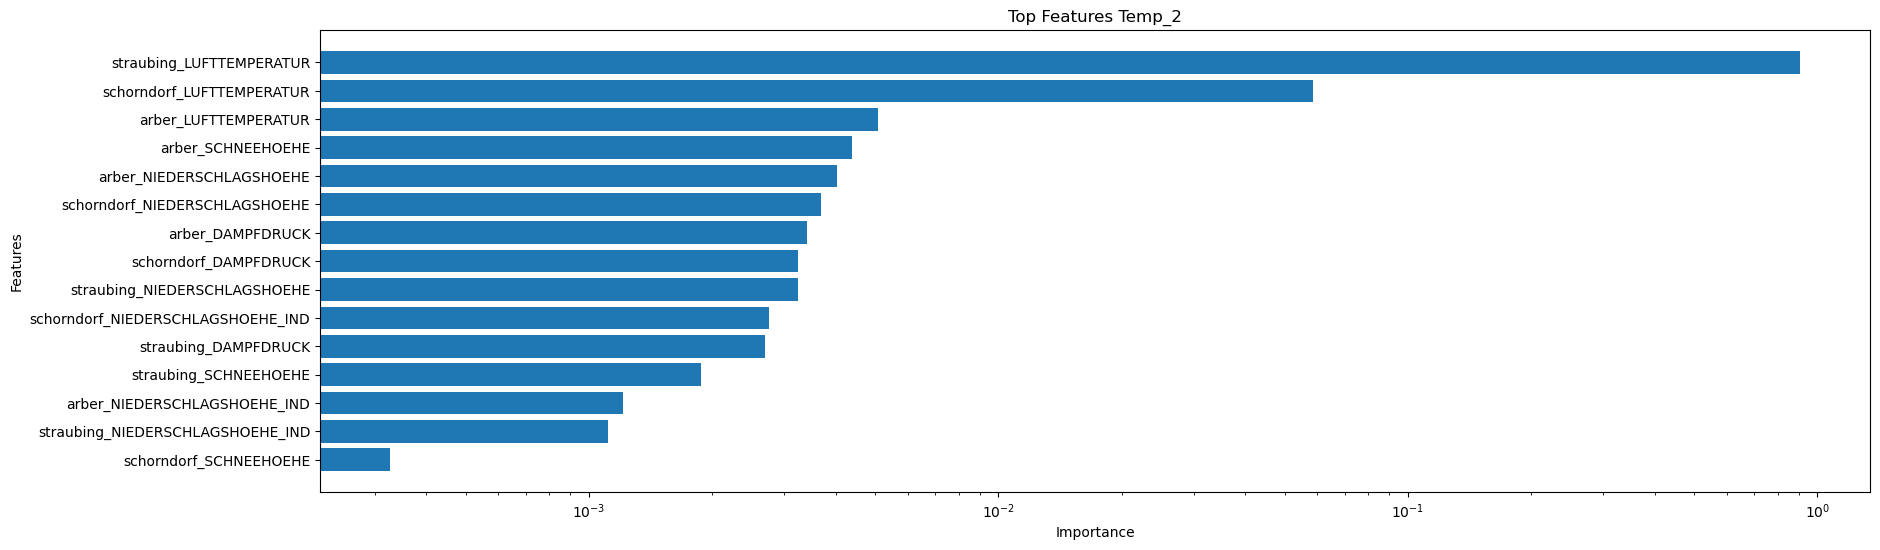

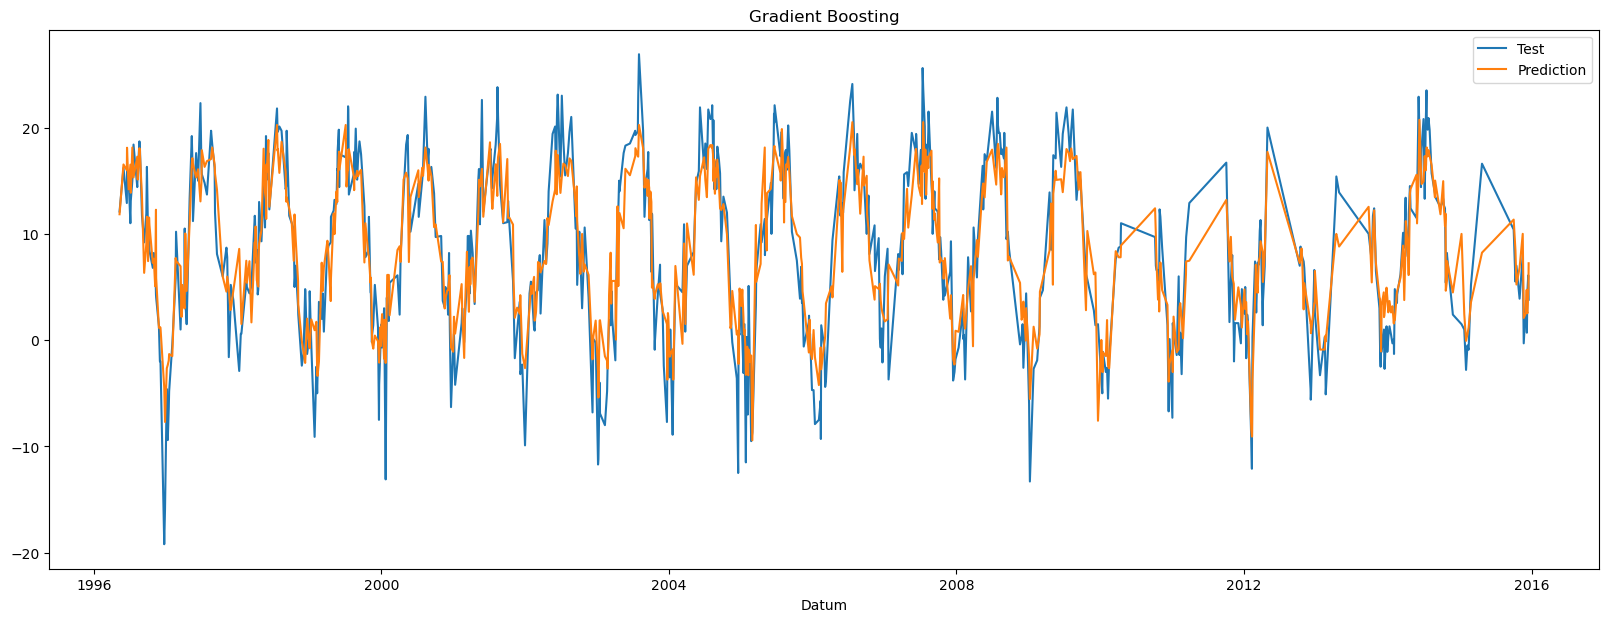

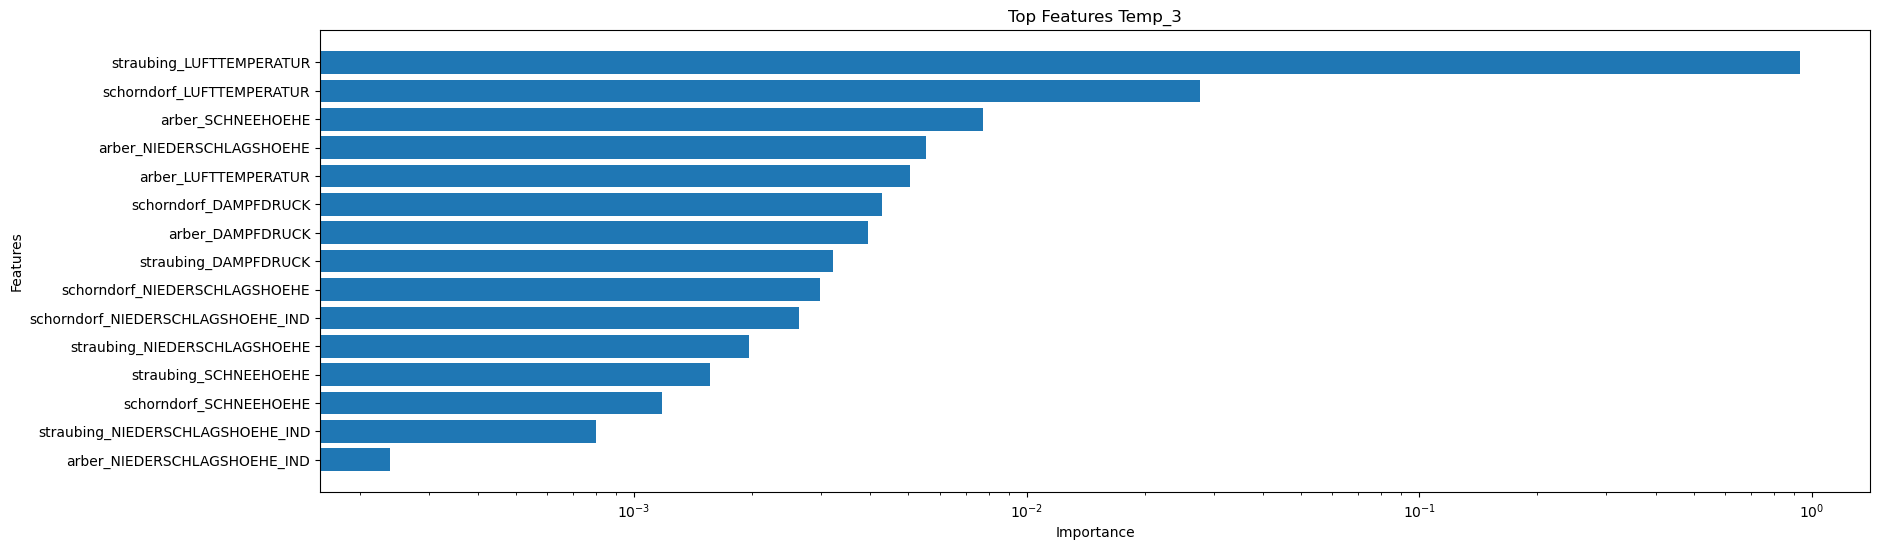

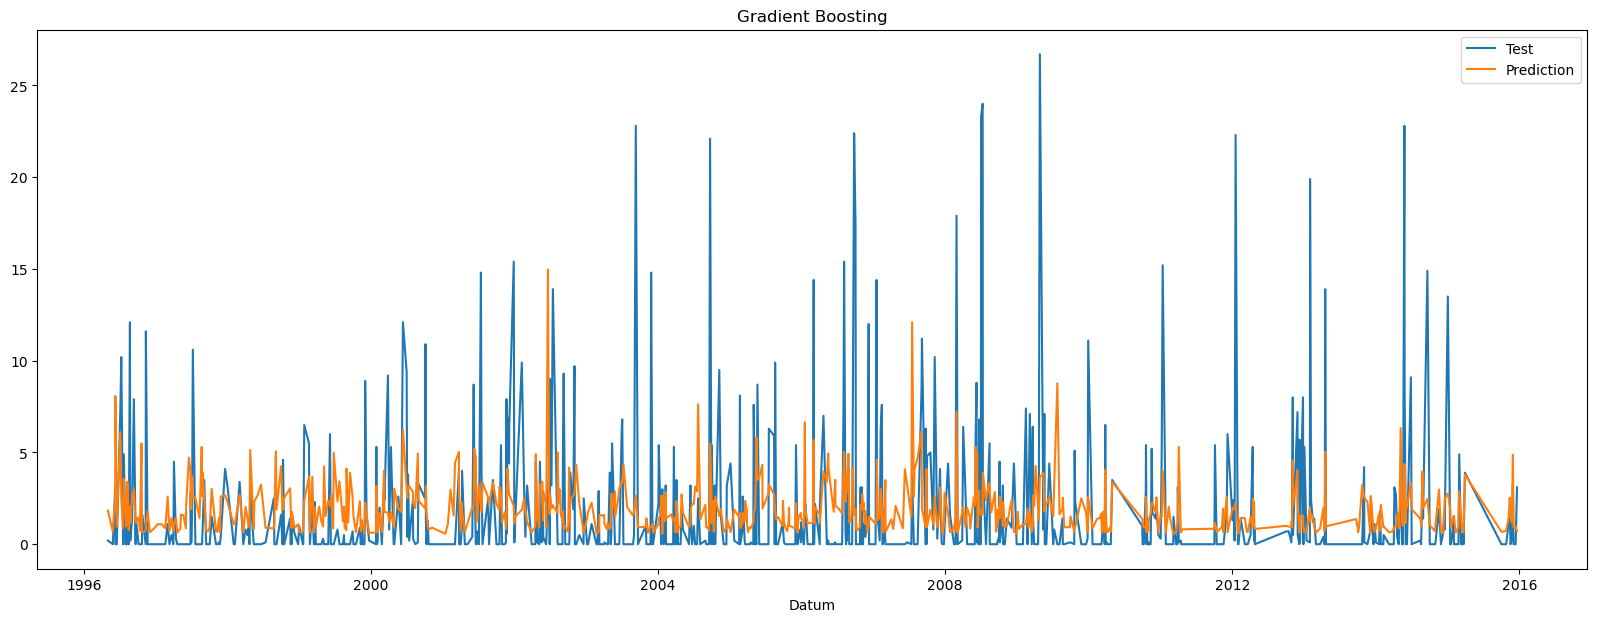

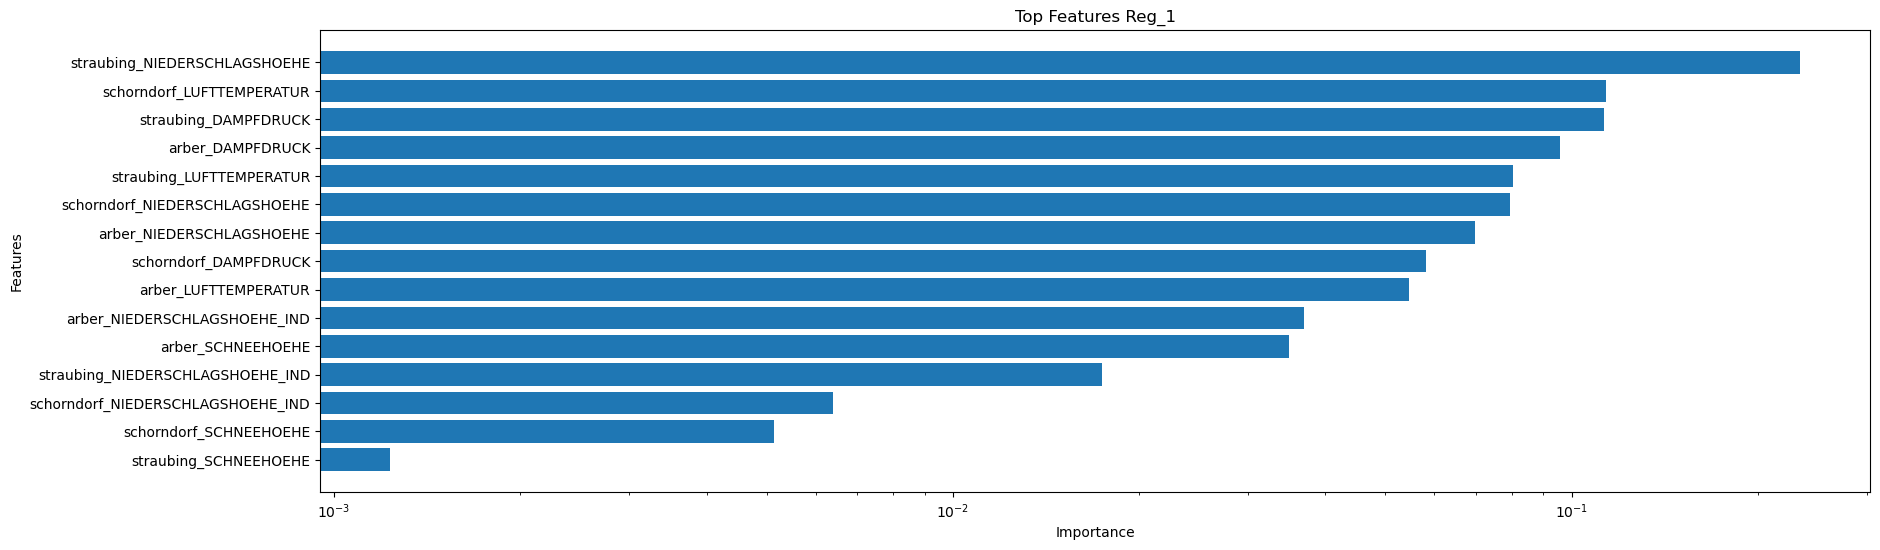

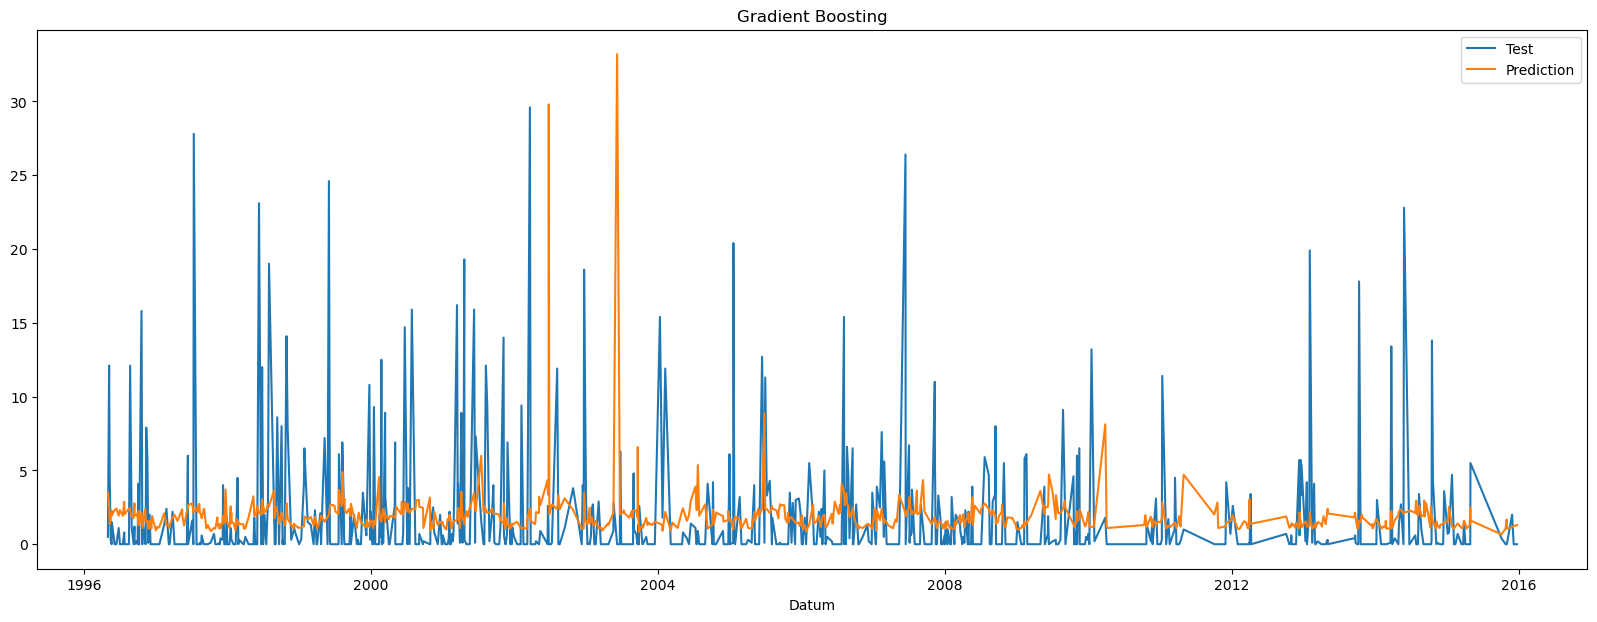

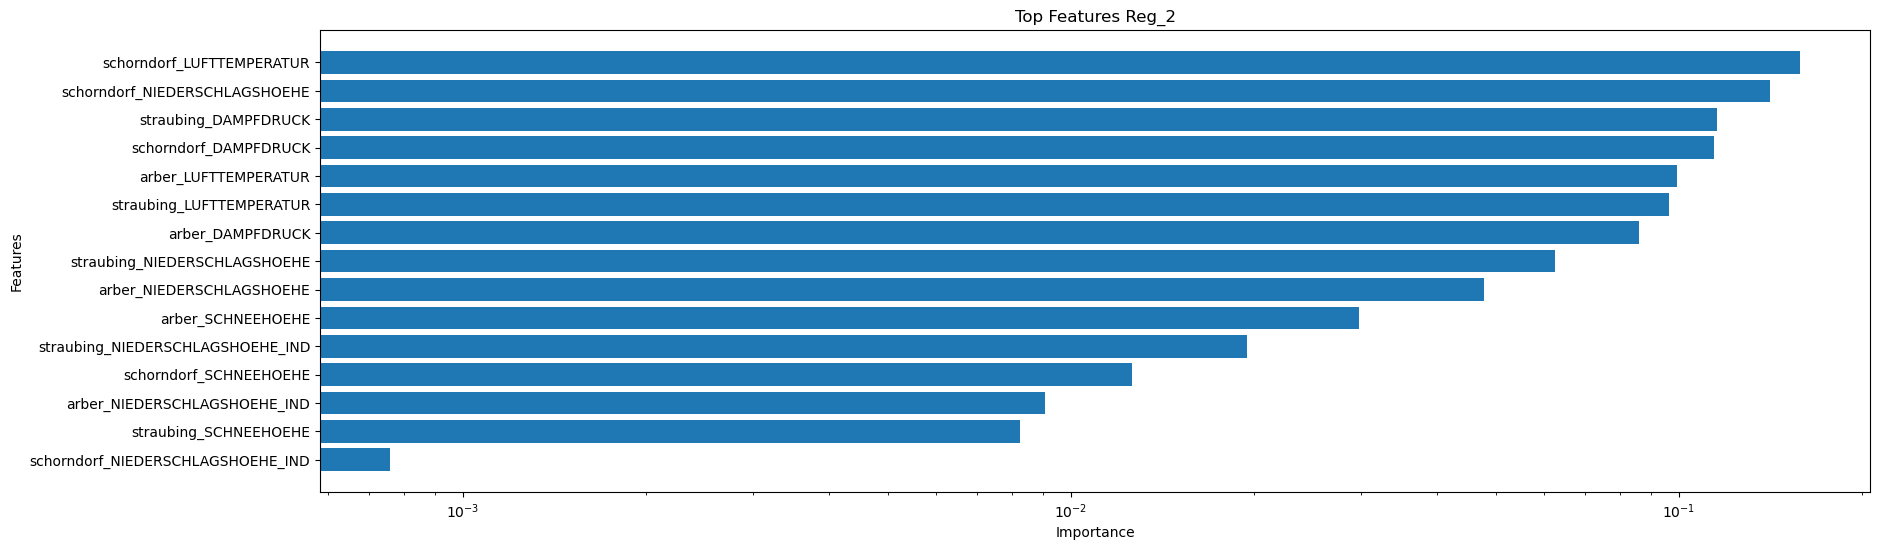

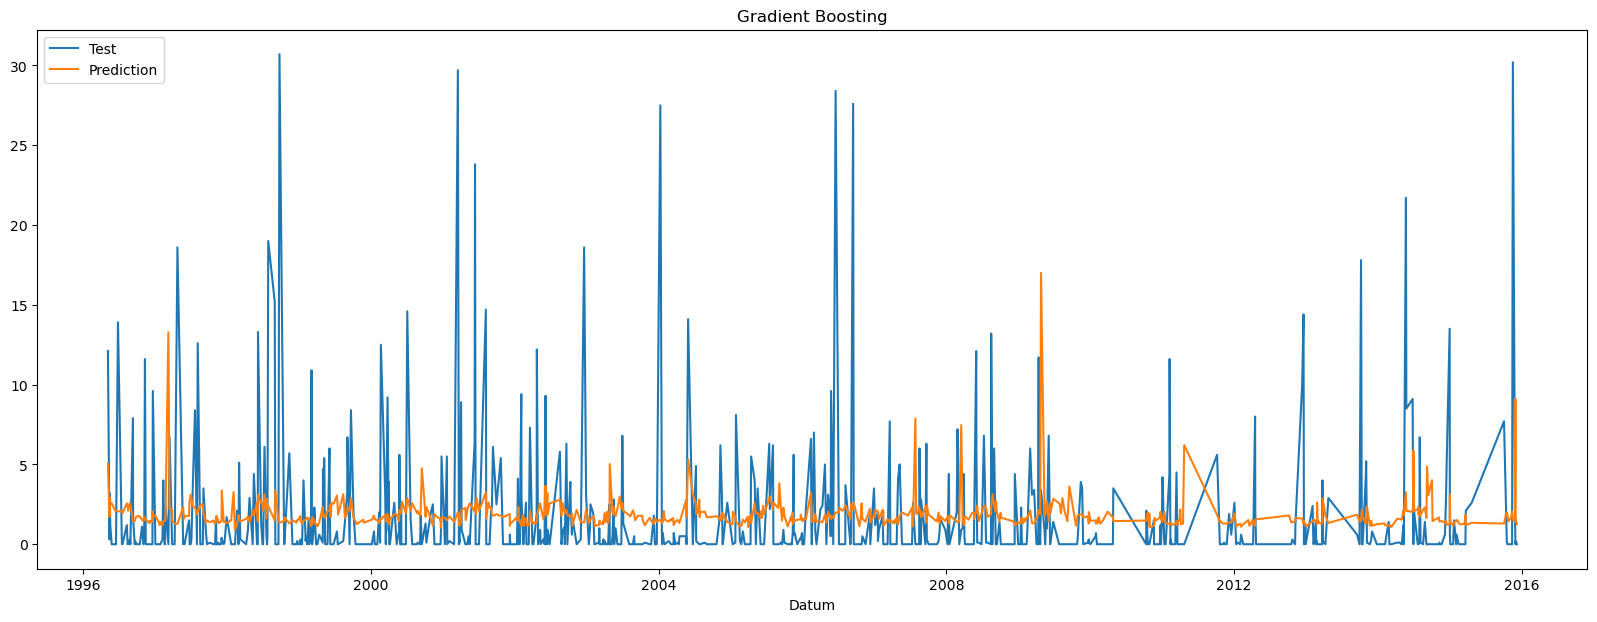

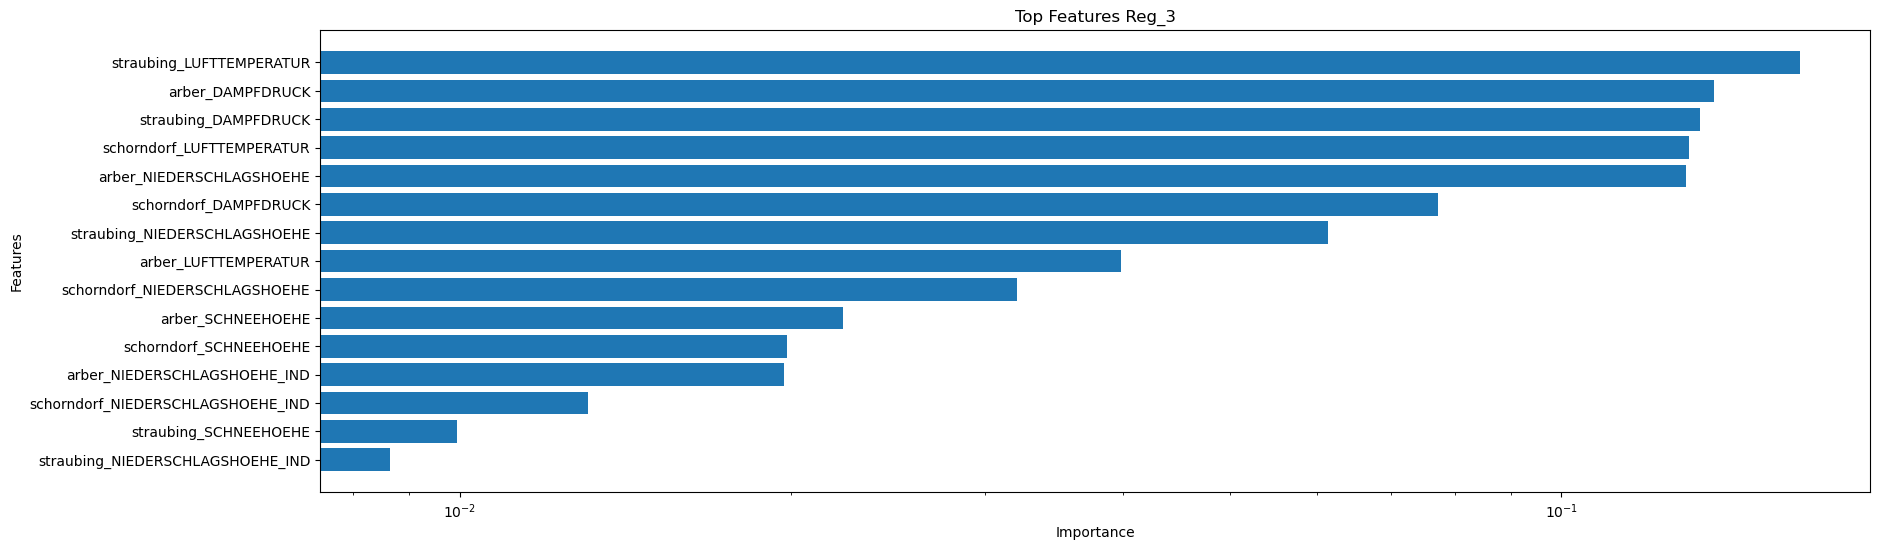

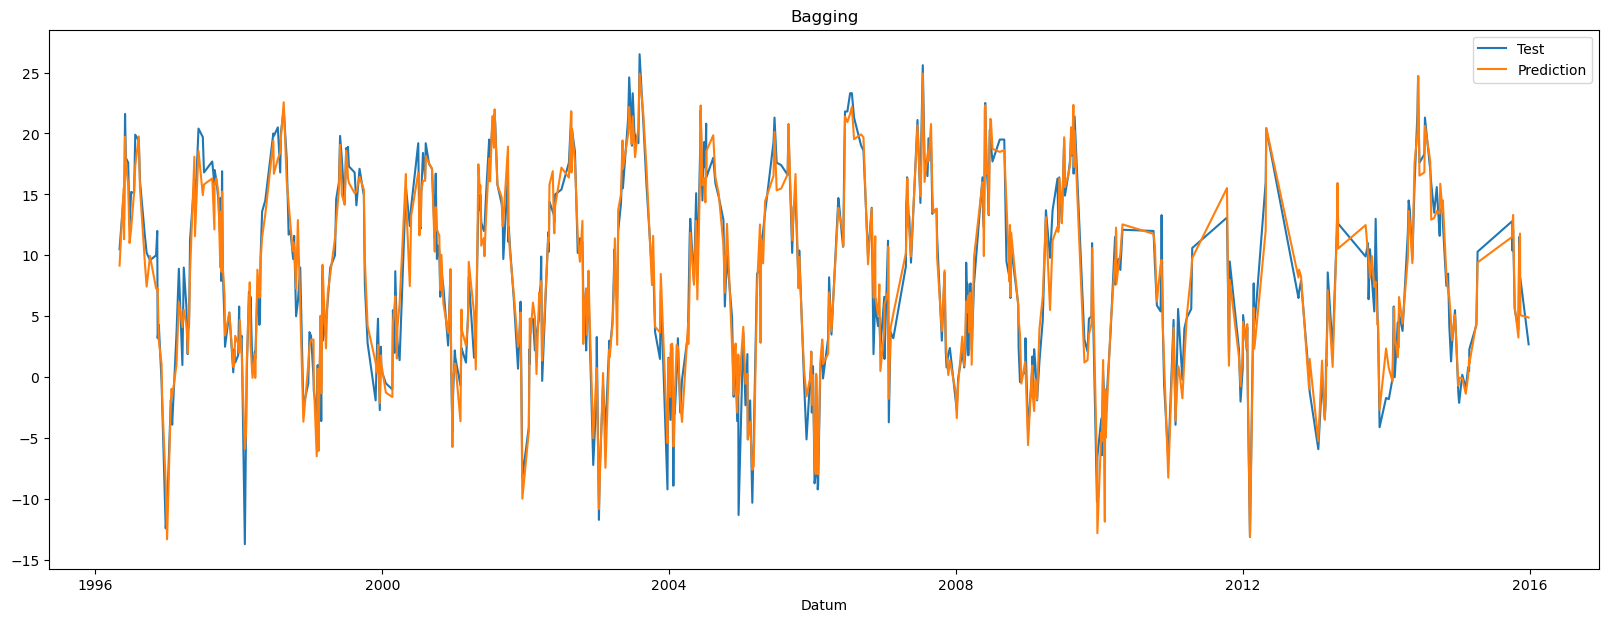

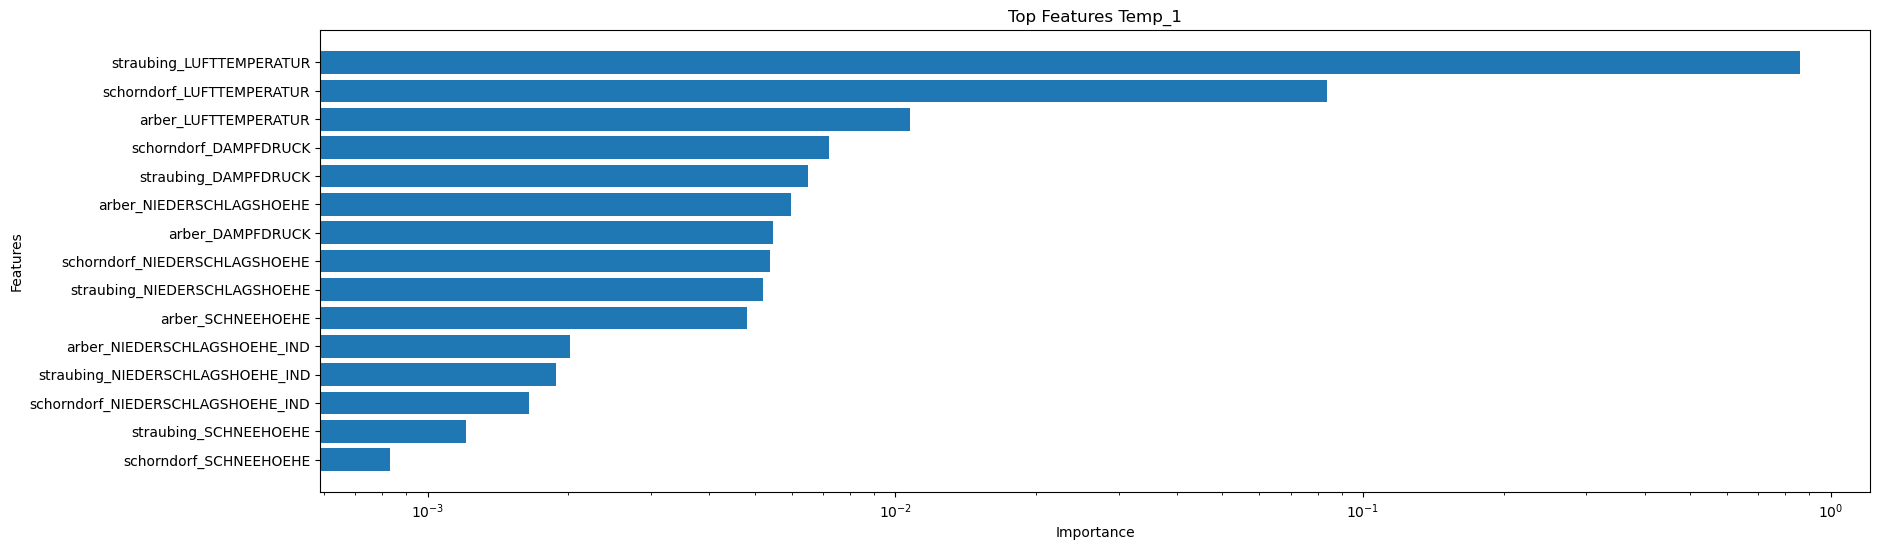

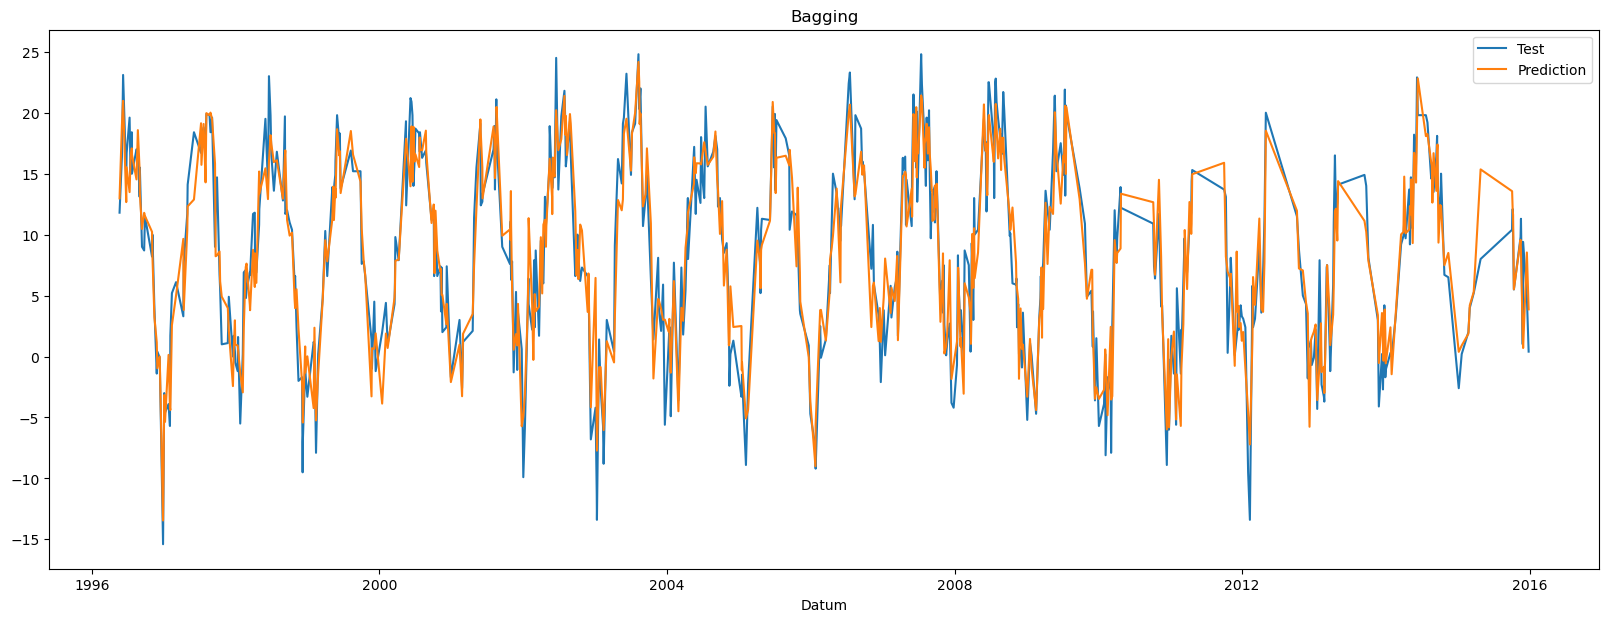

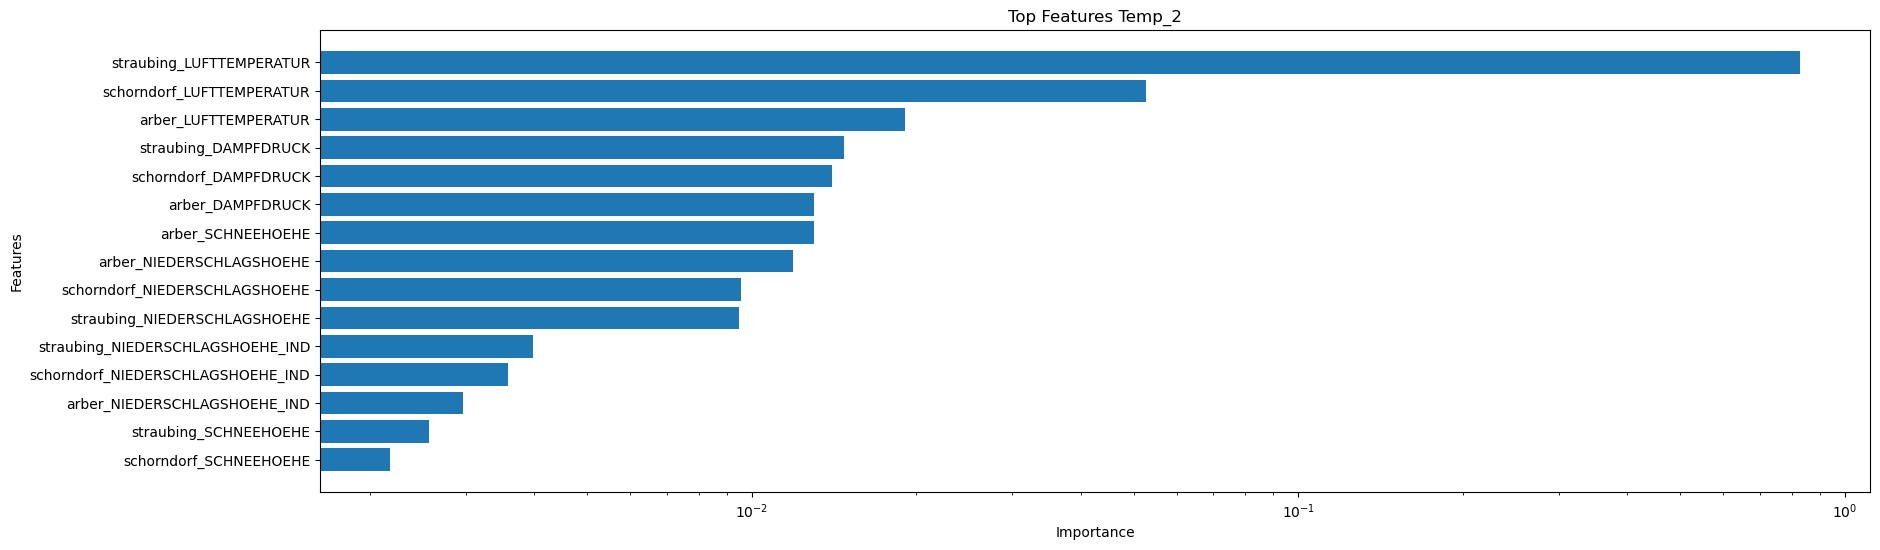

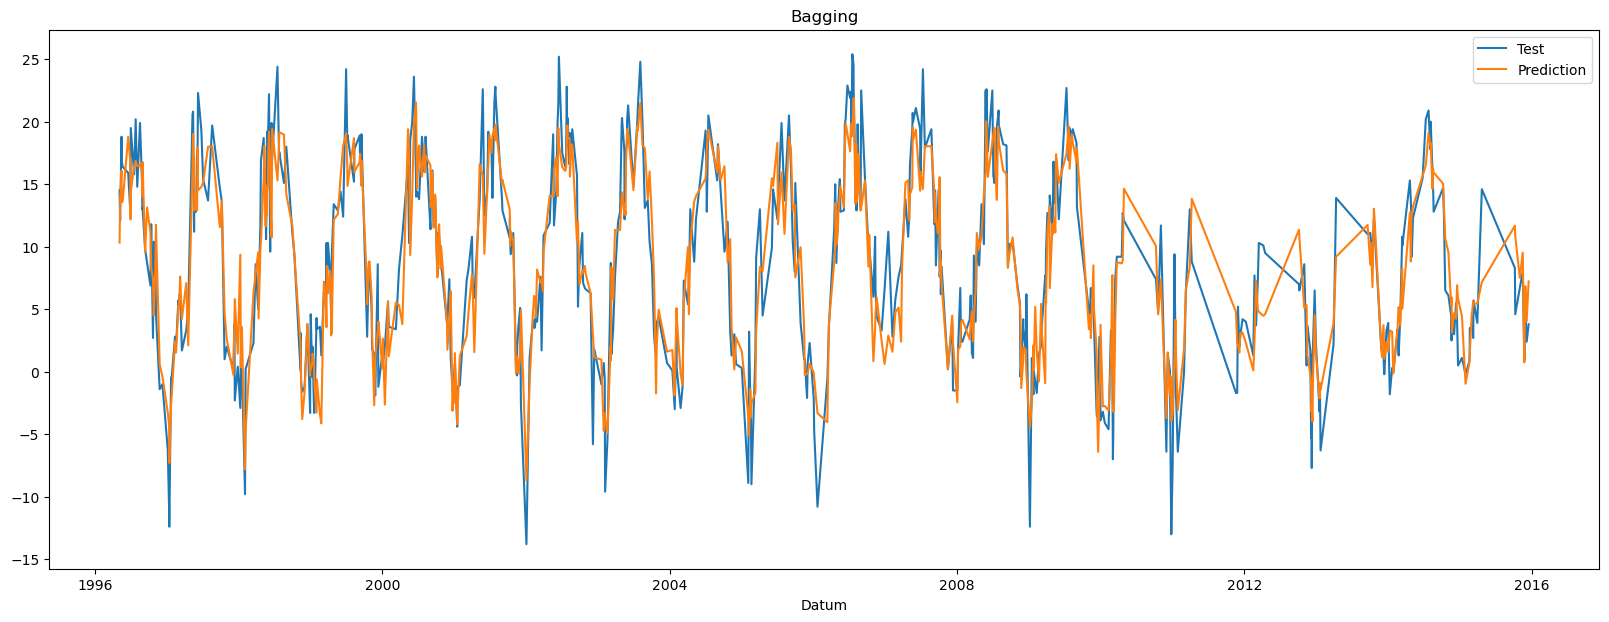

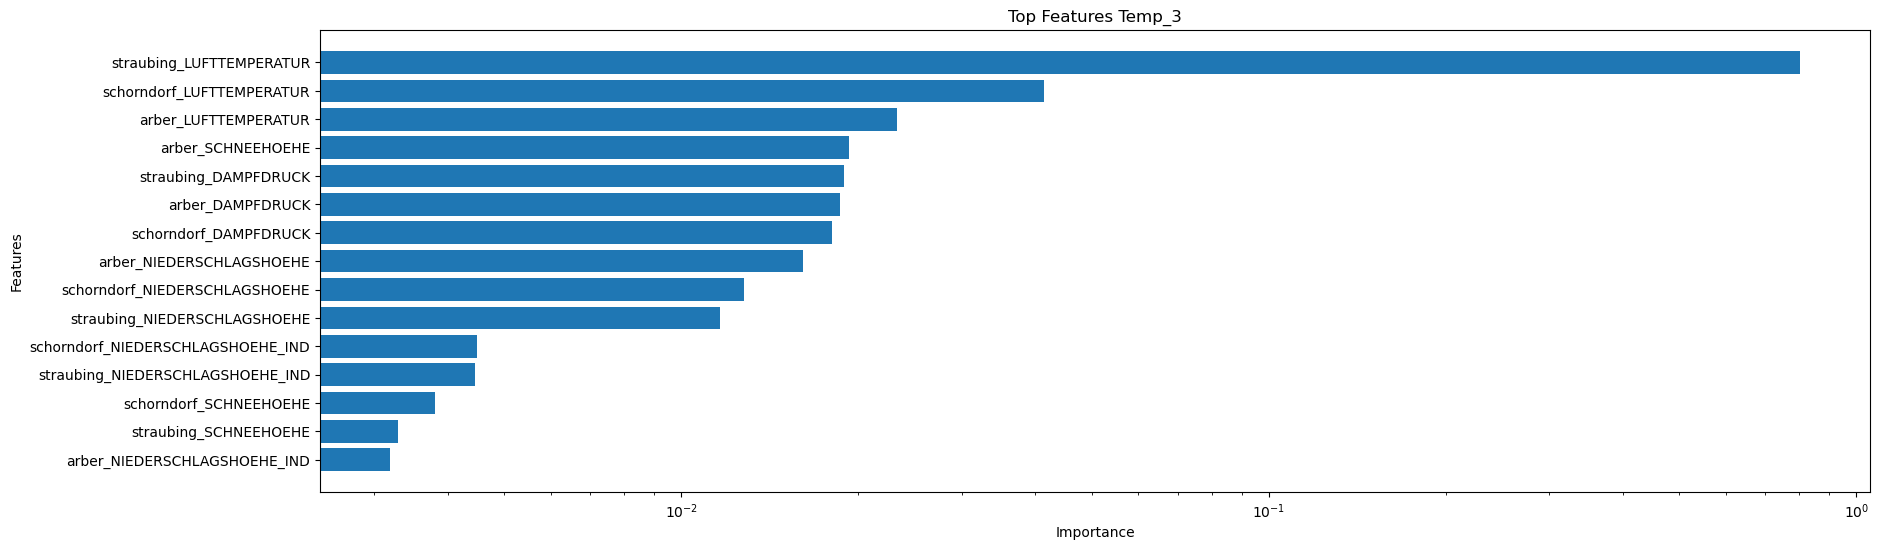

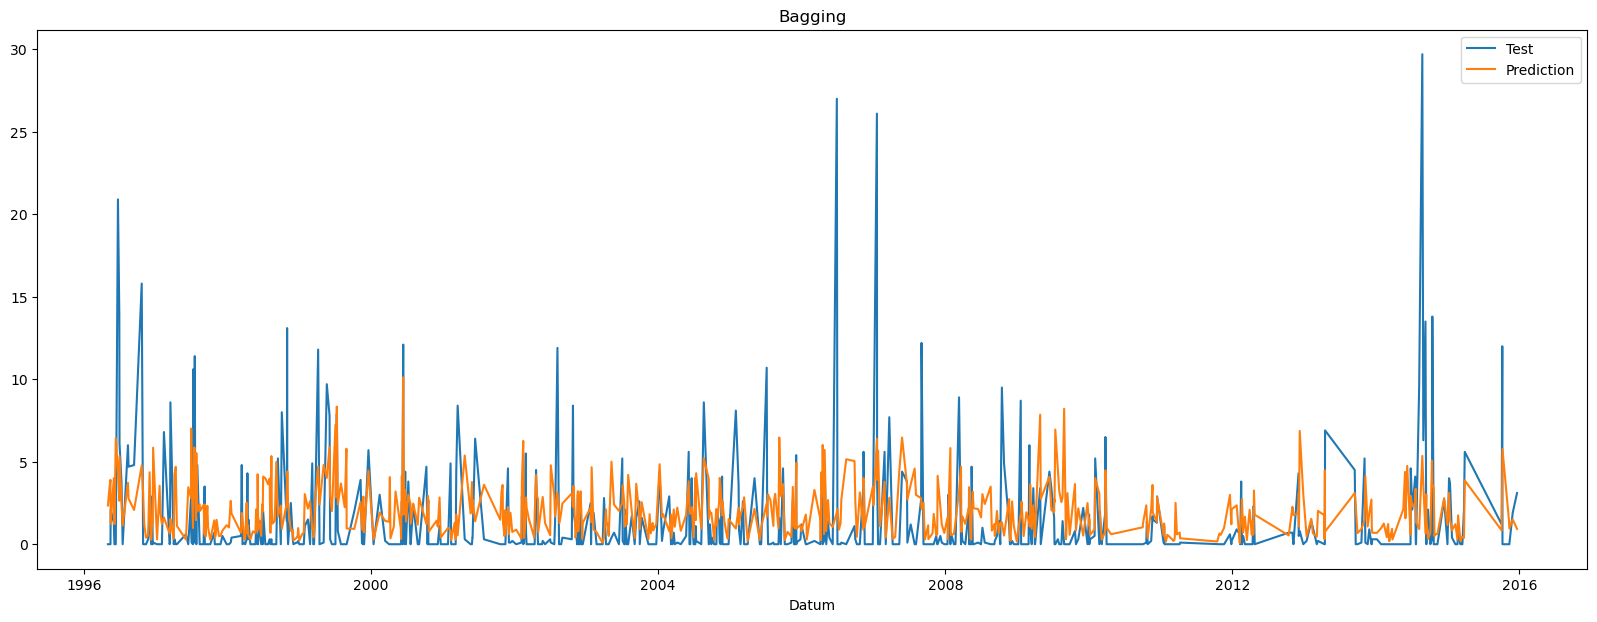

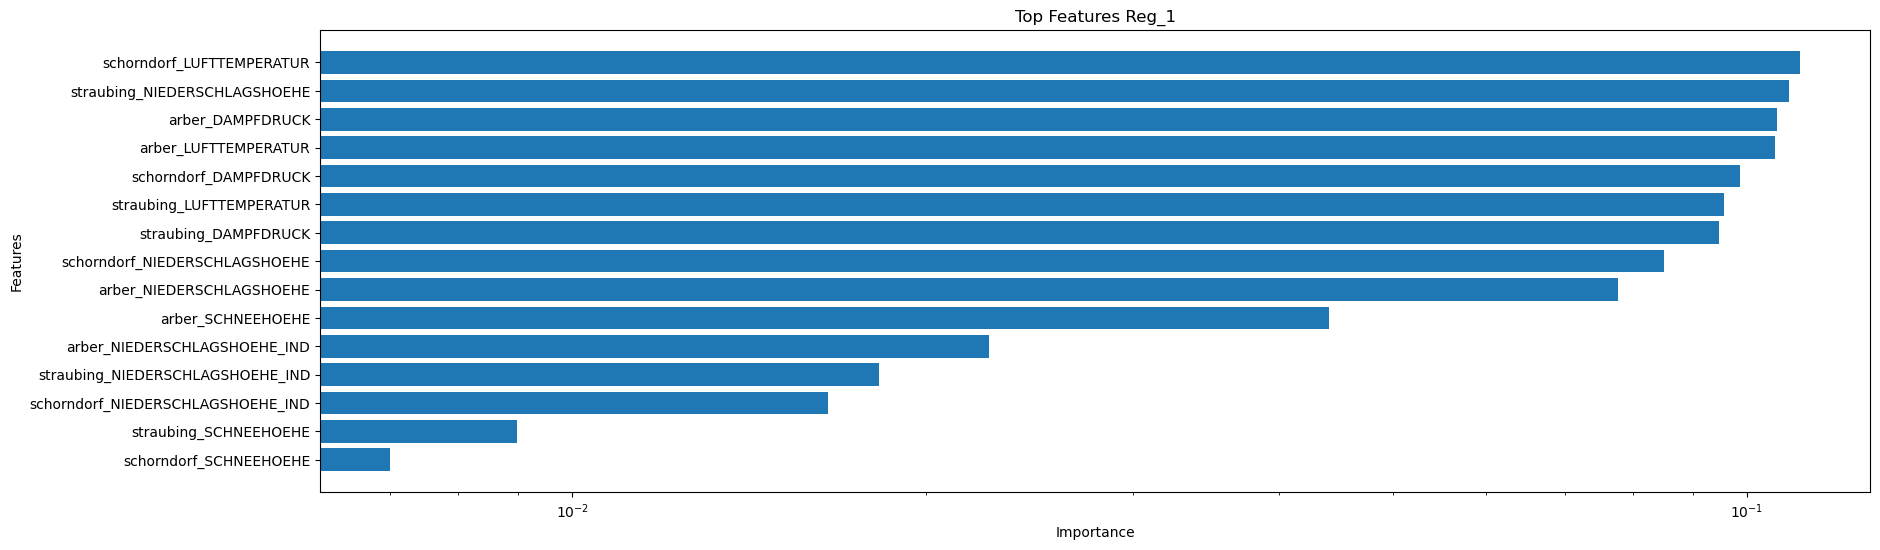

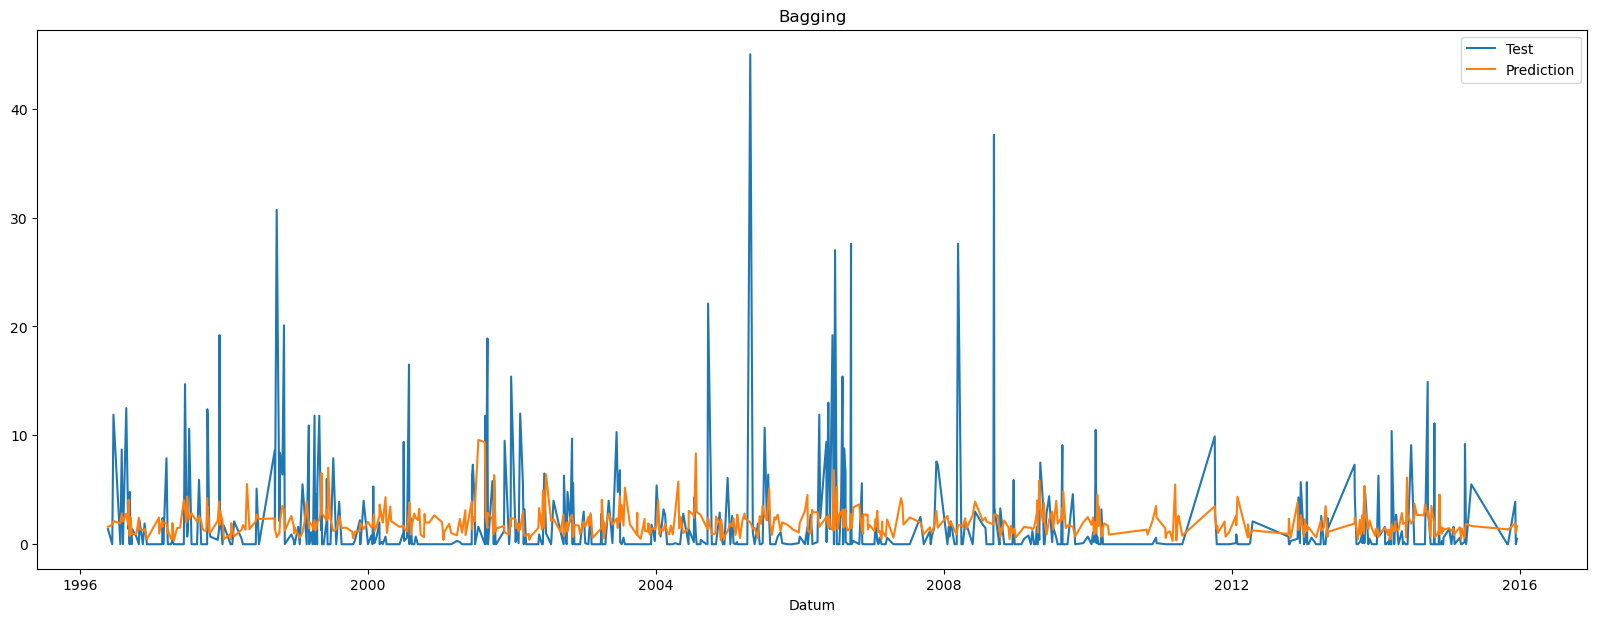

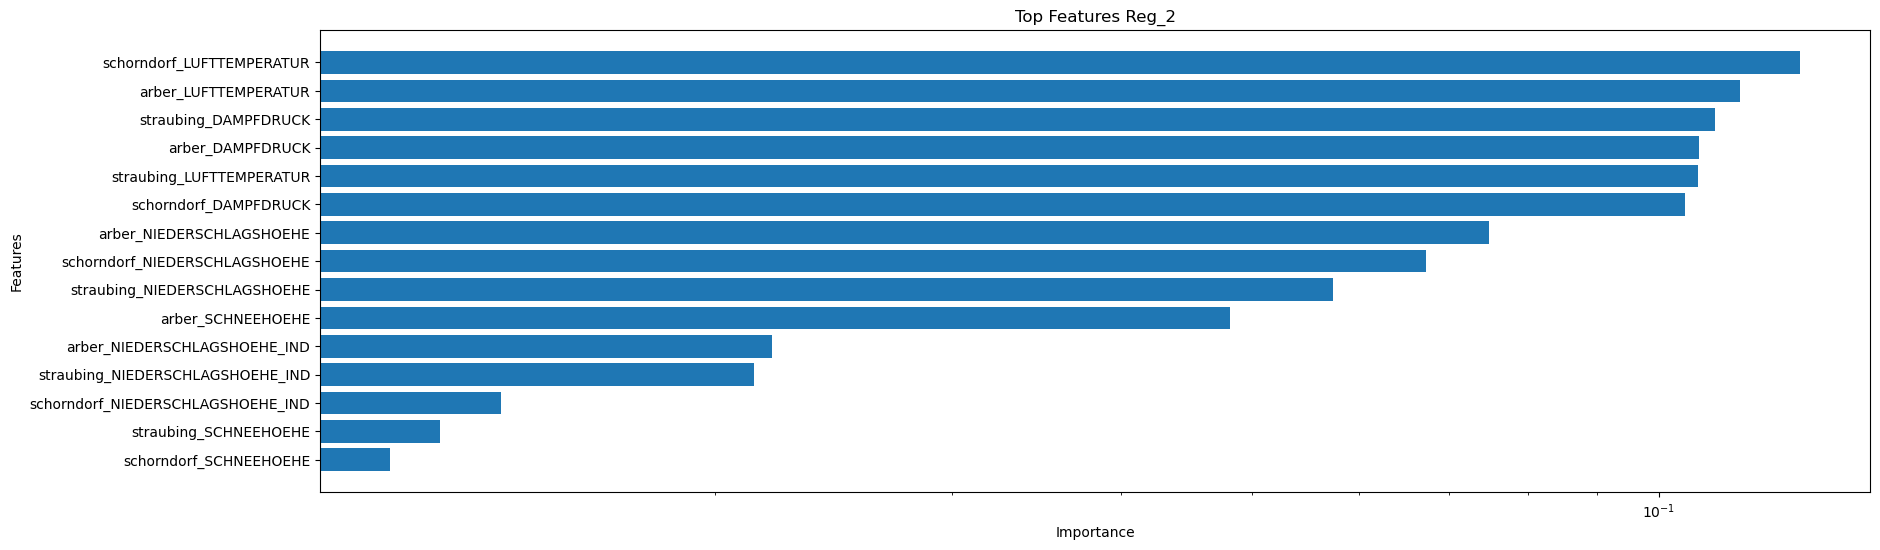

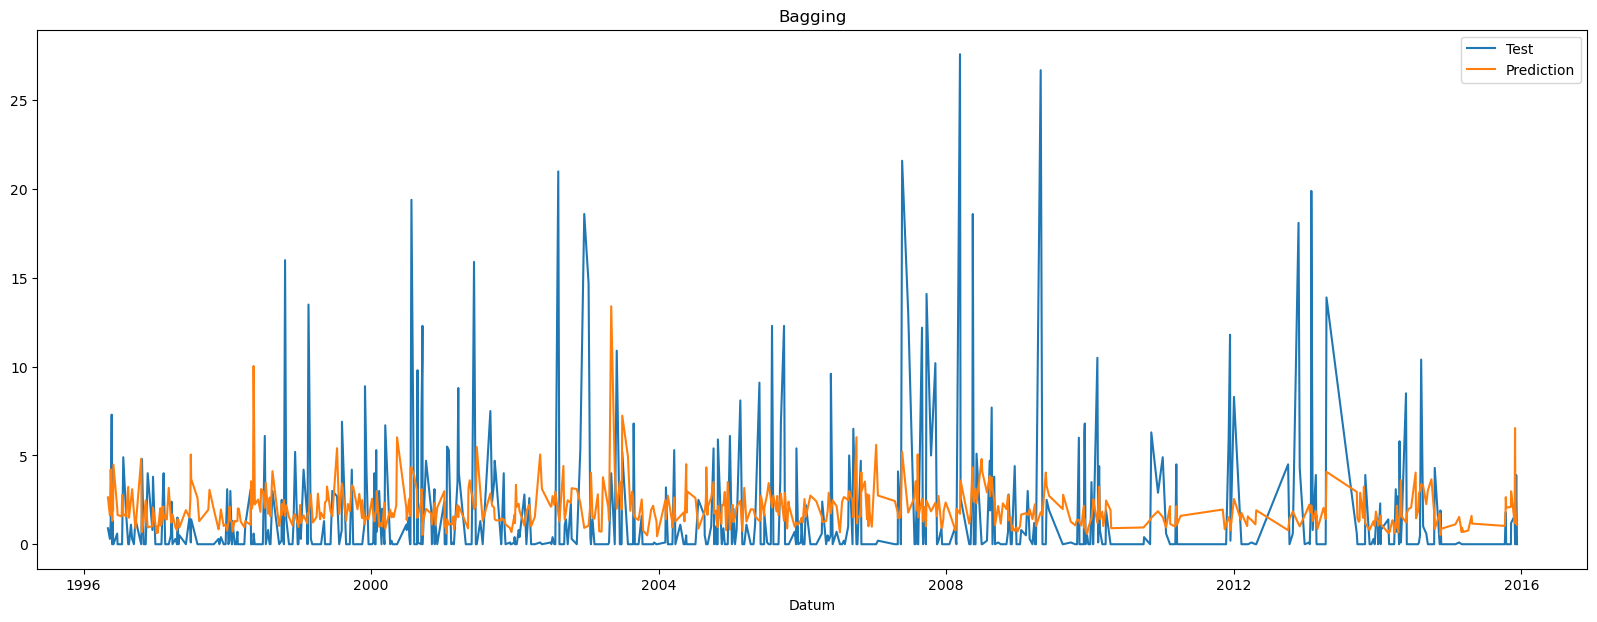

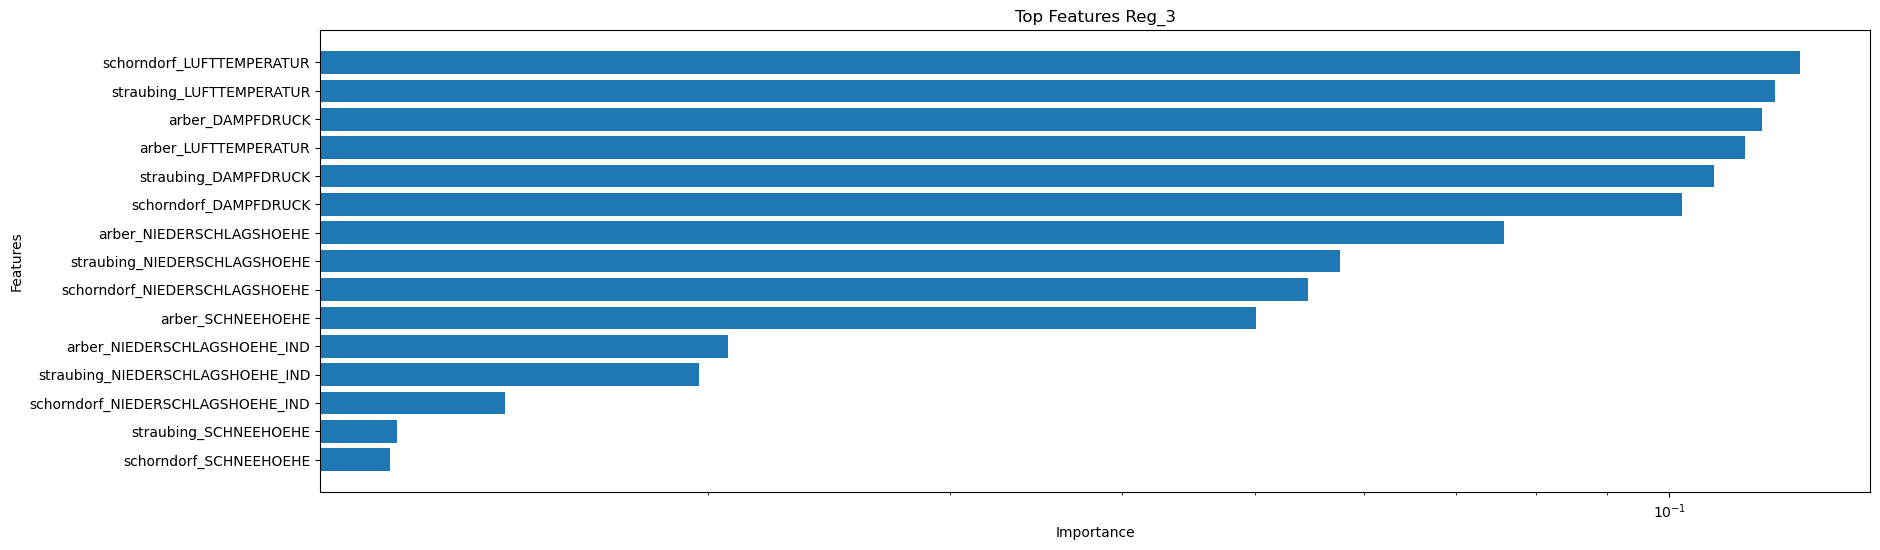

In [13]:
for target in ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]:
    X_train, X_test, y_train, y_test, D_train, D_test = train_test_split(X_Val, globals()[f"Y_{target}"], D, test_size=best_values[f'split_RF_avg'])
    rf_regressor = RandomForestRegressor(n_estimators=round(best_values[f'estimator_RF_avg']), n_jobs=-1, max_depth=round(best_values[f'depth_RF_avg']))
    rf_regressor.fit(X_train, y_train)
    y_pred_test = rf_regressor.predict(X_test)
    
    D_test['y_test'] = y_test
    D_test['y_pred'] = y_pred_test
    D_sorted = D_test.sort_values(by='straubing_DATE')
    D_sorted = D_sorted.reset_index(drop=True)

    plt.figure(figsize=(20, 7))
    plt.plot(D_sorted['straubing_DATE'], D_sorted['y_test'], label="Test")
    plt.plot(D_sorted['straubing_DATE'], D_sorted['y_pred'], label="Prediction")
    plt.xlabel('Datum')
    plt.title('Random Forest')
    plt.legend()
    plt.savefig(f'compare_RF_{target}.png')
    plt.show()

    feature_importances = rf_regressor.feature_importances_
    feature_names = X.columns

    sorted_indices = np.argsort(feature_importances)
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importances = feature_importances[sorted_indices]
    
    plt.figure(figsize=(20, 6))
    plt.barh(range(len(sorted_features)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.ylabel('Features')
    plt.xlabel('Importance')
    plt.title(f'Top Features {target}')
    plt.xscale('log')
    plt.savefig(f'top_features_RF_{target}.png')
    plt.show()

for target in ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]:
    X_train, X_test, y_train, y_test, D_train, D_test = train_test_split(X_Val, globals()[f"Y_{target}"], D, test_size=best_values[f'split_GB_avg'])
    gb_regressor = GradientBoostingRegressor(n_estimators=round(best_values[f'estimator_GB_avg']), max_depth=round(best_values[f'depth_GB_avg']))
    gb_regressor.fit(X_train, y_train)
    y_pred_test = gb_regressor.predict(X_test)
    
    D_test['y_test'] = y_test
    D_test['y_pred'] = y_pred_test
    D_sorted = D_test.sort_values(by='straubing_DATE')
    D_sorted = D_sorted.reset_index(drop=True)

    plt.figure(figsize=(20, 7))
    plt.plot(D_sorted['straubing_DATE'], D_sorted['y_test'], label="Test")
    plt.plot(D_sorted['straubing_DATE'], D_sorted['y_pred'], label="Prediction")
    plt.xlabel('Datum')
    plt.title('Gradient Boosting')
    plt.legend()
    plt.savefig(f'compare_GB_{target}.png')
    plt.show()

    feature_importances = gb_regressor.feature_importances_
    feature_names = X.columns

    sorted_indices = np.argsort(feature_importances)
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importances = feature_importances[sorted_indices]
    
    plt.figure(figsize=(20, 6))
    plt.barh(range(len(sorted_features)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.ylabel('Features')
    plt.xlabel('Importance')
    plt.title(f'Top Features {target}')
    plt.xscale('log')
    plt.savefig(f'top_features_GB_{target}.png')
    plt.show()

for target in ["Temp_1", "Temp_2", "Temp_3", "Reg_1", "Reg_2", "Reg_3"]:
    X_train, X_test, y_train, y_test, D_train, D_test = train_test_split(X_Val, globals()[f"Y_{target}"], D, test_size=best_values[f'split_BG_avg'])
    bg_regressor = BaggingRegressor(
        estimator=RandomForestRegressor(n_estimators=round(best_values[f'estimator_BG_avg']), n_jobs=-1, max_depth=round(best_values[f'depth_BG_avg'])), 
        n_estimators=round(best_values[f'estimator_BG_avg']))
    bg_regressor.fit(X_train, y_train)
    y_pred_test = bg_regressor.predict(X_test)
    
    D_test['y_test'] = y_test
    D_test['y_pred'] = y_pred_test
    D_sorted = D_test.sort_values(by='straubing_DATE')
    D_sorted = D_sorted.reset_index(drop=True)

    plt.figure(figsize=(20, 7))
    plt.plot(D_sorted['straubing_DATE'], D_sorted['y_test'], label="Test")
    plt.plot(D_sorted['straubing_DATE'], D_sorted['y_pred'], label="Prediction")
    plt.xlabel('Datum')
    plt.title('Bagging')
    plt.legend()
    plt.savefig(f'compare_BG_{target}.png')
    plt.show()

    feature_importances = np.mean([tree.feature_importances_ for tree in bg_regressor.estimators_], axis=0)
    feature_names = X.columns
    
    sorted_indices = np.argsort(feature_importances)
    sorted_features = [feature_names[i] for i in sorted_indices]
    sorted_importances = feature_importances[sorted_indices]
    
    plt.figure(figsize=(20, 6))
    plt.barh(range(len(sorted_features)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.ylabel('Features')
    plt.xlabel('Importance')
    plt.title(f'Top Features {target}')
    plt.xscale('log')
    plt.savefig(f'top_features_BG_{target}.png')
    plt.show()

# Fazit
Die Temperatur kann verhältnissmäßig gut vorhergesagt werden allerdings werden viele Extremwerte werden nicht predicted und einfach abgeschnitten.
Der Niederschlag kann hingegen mit den vorhandenen daten nicht vorhergesagt werden.
Weiterführend könnte hier noch `pruning` angewendet werden um zu testen, ob bessere ergebnisse möglich sind.
